In [1]:
# Install packages
!pip install -q mlxtend networkx wordcloud

In [2]:
# Core imports
import os, glob, gc, warnings, itertools, ast, re, math, random

# Data & plotting
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

# NLP
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer

# Graphs / association mining / word cloud
import networkx as nx
from collections import Counter
from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules
from wordcloud import WordCloud

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)


In [3]:
# Warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
pd.options.mode.chained_assignment = None  # suppress SettingWithCopyWarning (use carefully)

/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packages/jupyter_client/session.py:203: DeprecationWarning: datetime.datetime.utcnow() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.now(datetime.UTC).
  return datetime.utcnow().replace(tzinfo=utc)
/usr/local/lib/python3.12/dist-packag

In [4]:
# Download NLTK
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [5]:
# Output Setup
# Directory to store all generated plots, CSVs, and reflection files
OUT_DIR = "Lab3_PatternMining_Jaben"
os.makedirs(OUT_DIR, exist_ok=True)
print(f"Output directory ready: {OUT_DIR}")

Output directory ready: Lab3_PatternMining_Jaben


In [6]:
# Upload files
from google.colab import files
uploaded = files.upload()

Saving cleaned_captions.csv to cleaned_captions.csv
Saving cleaned_comments.csv to cleaned_comments.csv


In [7]:
# Load cleaned data
comments = pd.read_csv("cleaned_comments.csv")
captions = pd.read_csv("cleaned_captions.csv")

# Verify cleaned column
assert 'cleaned_tokens' in comments.columns, "cleaned_tokens missing in comments"
assert 'cleaned_tokens' in captions.columns, "cleaned_tokens missing in captions"
print("Cleaned_tokens column found in both datasets.\n")

# Convert to list
def to_list(x):
    if pd.isna(x):
        return []
    if isinstance(x, list):
        return x
    try:
        return list(ast.literal_eval(x))
    except:
        return str(x).split()

comments['cleaned_tokens'] = comments['cleaned_tokens'].apply(to_list)
captions['cleaned_tokens'] = captions['cleaned_tokens'].apply(to_list)

# Drop empty tokens
before_comments = len(comments)
before_captions = len(captions)

comments = comments[comments['cleaned_tokens'].map(len) > 0].reset_index(drop=True)
captions = captions[captions['cleaned_tokens'].map(len) > 0].reset_index(drop=True)

print(f"Dropped {before_comments - len(comments)} empty rows from comments.")
print(f"Dropped {before_captions - len(captions)} empty rows from captions.\n")

# Sanity check
print("Sample tokens from comments:")
print(comments['cleaned_tokens'].head(3).to_list())
print("\nSample tokens from captions:")
print(captions['cleaned_tokens'].head(3).to_list())

Cleaned_tokens column found in both datasets.

Dropped 38 empty rows from comments.
Dropped 0 empty rows from captions.

Sample tokens from comments:
[['good', 'probably', 'need', 'updated', 'example', 'used', 'spotify', 'amp', 'twilo', 'outdated'], ['amazing'], ['ngl', 'giant', 'twilio', 'advertisement']]

Sample tokens from captions:
[['course', 'excellent', 'introduction', 'apis', 'beginner', 'updated', 'apis', 'beginner', 'updated', 'apis', 'beginner', 'updated', 'version', 'already', 'one', 'version', 'already', 'one', 'version', 'already', 'one', 'popular', 'api', 'course', 'internet', 'popular', 'api', 'course', 'internet', 'popular', 'api', 'course', 'internet', 'craig', 'dennis', 'back', 'instructor', 'craig', 'dennis', 'back', 'instructor', 'craig', 'dennis', 'back', 'instructor', 'opinion', 'one', 'best', 'opinion', 'one', 'best', 'opinion', 'one', 'best', 'developer', 'educator', 'hello', 'craig', 'developer', 'course', 'craig', 'developer', 'course', 'craig', 'developer', 

In [8]:
# Top 20 unigrams for comments
all_tokens_comments = list(itertools.chain.from_iterable(comments['cleaned_tokens']))
unigram_counts_comments = Counter(all_tokens_comments)
top20_comments = unigram_counts_comments.most_common(20)
df_comments = pd.DataFrame(top20_comments, columns=['token','count'])

# Top 20 unigrams for captions
all_tokens_captions = list(itertools.chain.from_iterable(captions['cleaned_tokens']))
unigram_counts_captions = Counter(all_tokens_captions)
top20_captions = unigram_counts_captions.most_common(20)
df_captions = pd.DataFrame(top20_captions, columns=['token','count'])

# Display
print("Top 20 Most Common Tokens")
display(pd.concat(
    [df_comments.rename(columns={'token':'comment_token','count':'comment_count'}),
     df_captions.rename(columns={'token':'caption_token','count':'caption_count'})],
    axis=1
))

Top 20 Most Common Tokens


comment_token  comment_count caption_token  caption_count
0           http            293         going           1878
1           href            289         right            701
2          watch            289           see            641
3        youtube            283           let            620
4            com            275           get            606
5            amp            274       message            567
6            www            272          want            546
7           wxsd            268           api            521
8         zgxjrw            268          like            514
9            api            201           one            484
10         video            138         thing            428
11          quot            126          back            388
12       spotify            116          look            373
13        course            108          make            340
14        twilio            106           say            326
15          like            106          know            322
16          apis             91           use            299
17         thank             87         could            296
18           get             81           got            280
19         using             75          code            265

Transactions created successfully!
Comments: 788 baskets
Captions: 52 baskets

Example comment basket: ['good', 'probably', 'need', 'updated', 'example', 'used', 'spotify', 'amp', 'twilo', 'outdated']
Example caption basket: ['course', 'excellent', 'introduction', 'apis', 'beginner', 'updated', 'version', 'already', 'one', 'popular', 'api', 'internet', 'craig', 'dennis', 'back', 'instructor', 'opinion', 'best', 'developer', 'educator', 'hello', 'going', 'exploring', 'term', 'probably', 'heard', 'quite', 'bit', 'application', 'programming', 'interface', 'addition', 'able', 'recite', 'stand', 'complete', 'discus', 'understand', 'exist', 'list', 'many', 'benefit', 'provide', 'even', 'get', 'hand', 'experience', 'using', 'web', 'give', 'taste', 'excitement', 'starting', 'beginning', 'really', 'much', 'expecting', 'know', 'would', 'like', 'request', 'touch', 'coding', 'knowledge', 'written', 'program', 'typical', 'first', 'write', 'word', 'world', 'done', 'language', 'pretty', 'ready', 'hel

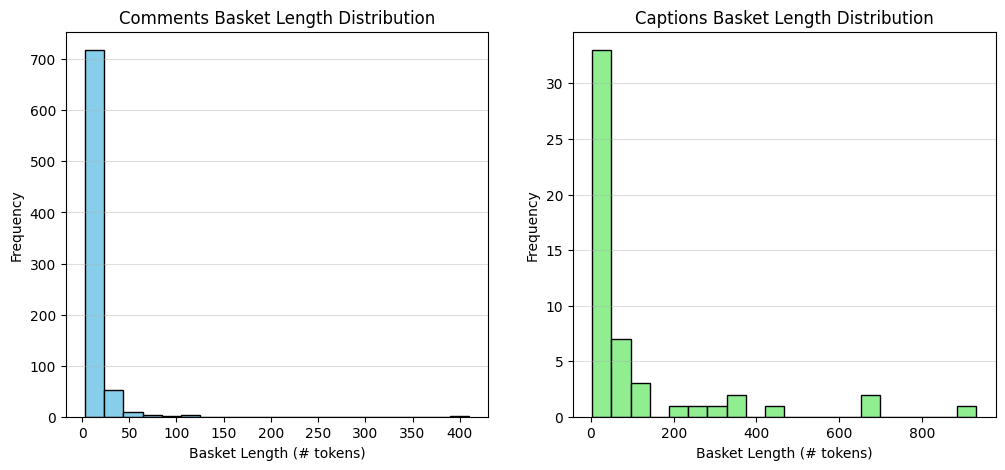


Comments Basket Statistics:
Average length: 11.87
Minimum length: 3
Maximum length: 410

Captions Basket Statistics:
Average length: 101.65
Minimum length: 3
Maximum length: 932


In [9]:
# Build transactions function
def make_transactions(df, min_len=3, dedup=False):
    transactions = []
    ids = []
    for i, tokens in enumerate(df['cleaned_tokens']):
        basket = tokens.copy()
        if dedup:
            basket = list(dict.fromkeys(basket))  # preserve order but remove duplicates
        if len(basket) >= min_len:
            transactions.append(basket)
            ids.append(i)
    return transactions, ids

# Build transactions for comments
transactions_comments, tx_ids_comments = make_transactions(comments, min_len=3, dedup=True)

# Build transactions for captions
transactions_captions, tx_ids_captions = make_transactions(captions, min_len=3, dedup=True)

# Print
print("Transactions created successfully!")
print(f"Comments: {len(transactions_comments)} baskets")
print(f"Captions: {len(transactions_captions)} baskets\n")

print("Example comment basket:", transactions_comments[0] if transactions_comments else "No baskets")
print("Example caption basket:", transactions_captions[0] if transactions_captions else "No baskets")

# Histogram of basket lengths
basket_lengths_comments = [len(t) for t in transactions_comments]
basket_lengths_captions = [len(t) for t in transactions_captions]

plt.figure(figsize=(12,5))

# Comments Plot
plt.subplot(1,2,1)
plt.hist(basket_lengths_comments, bins=20, color='skyblue', edgecolor='black')
plt.title("Comments Basket Length Distribution")
plt.xlabel("Basket Length (# tokens)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.4)

# Captions Plot
plt.subplot(1,2,2)
plt.hist(basket_lengths_captions, bins=20, color='lightgreen', edgecolor='black')
plt.title("Captions Basket Length Distribution")
plt.xlabel("Basket Length (# tokens)")
plt.ylabel("Frequency")
plt.grid(axis='y', alpha=0.4)

# Save
out_path = os.path.join(OUT_DIR, "basket_length_distribution.png")
plt.savefig(out_path, dpi=200, bbox_inches="tight")
print(f"Saved basket length plot to: {out_path}")

plt.show()
plt.close()

# Print statistics
def basket_stats(name, lengths):
    if not lengths:
        print(f"\n{name}: No valid baskets.")
        return
    print(f"\n{name} Basket Statistics:")
    print(f"Average length: {np.mean(lengths):.2f}")
    print(f"Minimum length: {np.min(lengths)}")
    print(f"Maximum length: {np.max(lengths)}")

basket_stats("Comments", basket_lengths_comments)
basket_stats("Captions", basket_lengths_captions)

In [10]:
# Initialize English stop words list from NLTK
stop_words = set(stopwords.words('english'))

def count_pairs(baskets, min_count=3, stop_words=stop_words):
    """
    Count co-occurring word pairs across baskets (transactions).

    """
    c = Counter()
    for t in baskets:
        # Remove stopwords from each basket before counting
        t = [w for w in t if w not in stop_words]

        # Count each unique pair only once per basket
        c.update(itertools.combinations(sorted(set(t)), 2))

    # Filter pairs with count >= min_count and sort descending by frequency
    pairs_sorted = sorted(
        [(a, b, n) for (a, b), n in c.items() if n >= min_count],
        key=lambda x: x[2],
        reverse=True
    )
    return pairs_sorted, c


# Compute frequent word pairs for comments and captions
pairs_comments, counter_comments = count_pairs(transactions_comments, min_count=3)
pairs_captions, counter_captions = count_pairs(transactions_captions, min_count=3)

# Display top 20 co-occurring pairs
df_comments = pd.DataFrame(pairs_comments[:20], columns=['word1', 'word2', 'count'])
df_captions = pd.DataFrame(pairs_captions[:20], columns=['word1', 'word2', 'count'])

display(
    pd.concat(
        [df_comments.add_prefix('comment_'),
         df_captions.add_prefix('caption_')],
        axis=1
    )
)

comment_word1 comment_word2  comment_count caption_word1 caption_word2  \
0           href          http            117         going           let   
1            com          href            116         going         right   
2            com          http            116           let         right   
3            com           www            116         going       message   
4            com       youtube            116         going           say   
5           href           www            116           get         going   
6           href       youtube            116          back         going   
7           http           www            116         going          know   
8           http       youtube            116         going          want   
9            www       youtube            116          know           let   
10          http         watch            115           let          want   
11         watch       youtube            115       message           one   
12           amp           com            114         right          want   
13           amp          href            114      actually           let   
14           amp          http            114      actually         right   
15           amp         watch            114          back           let   
16           amp           www            114           get           let   
17           amp          wxsd            114         going          look   
18           amp       youtube            114         going          make   
19           amp        zgxjrw            114         going           one   

    caption_count  
0              22  
1              22  
2              22  
3              21  
4              21  
5              20  
6              19  
7              19  
8              19  
9              19  
10             19  
11             19  
12             19  
13             18  
14             18  
15             18  
16             18  
17             18  
18             18  
19             18

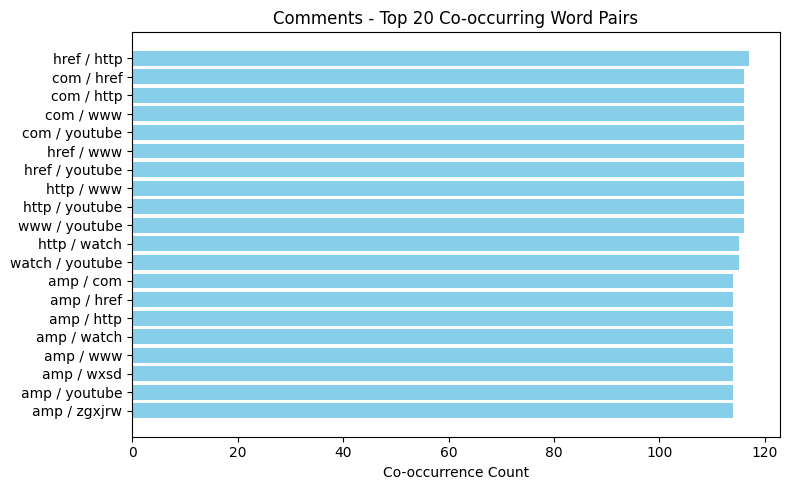

Saved: Lab3_PatternMining_Jaben/comments_top20_pairs.png


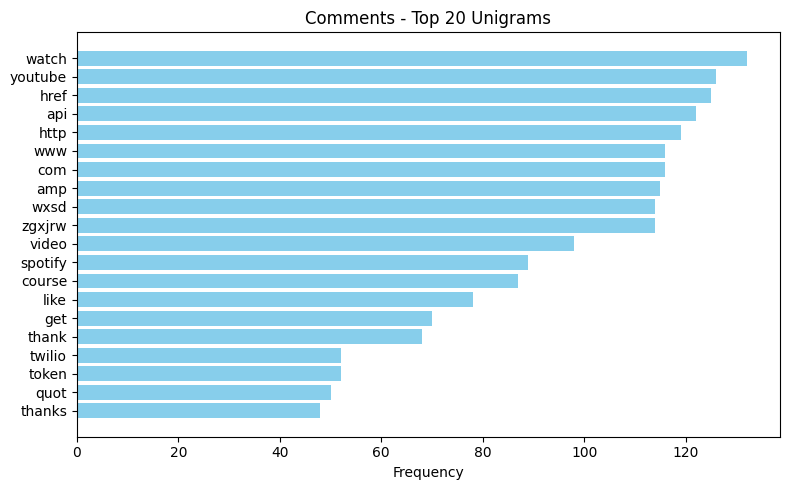

Saved: Lab3_PatternMining_Jaben/comments_top20_unigrams.png


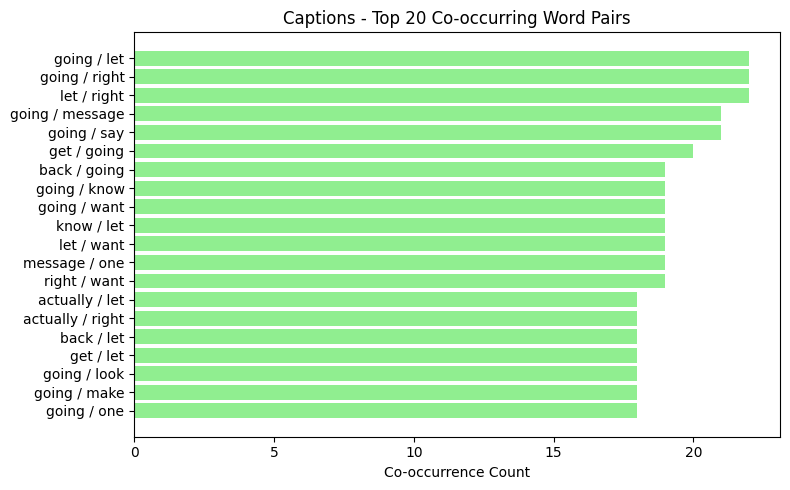

Saved: Lab3_PatternMining_Jaben/captions_top20_pairs.png


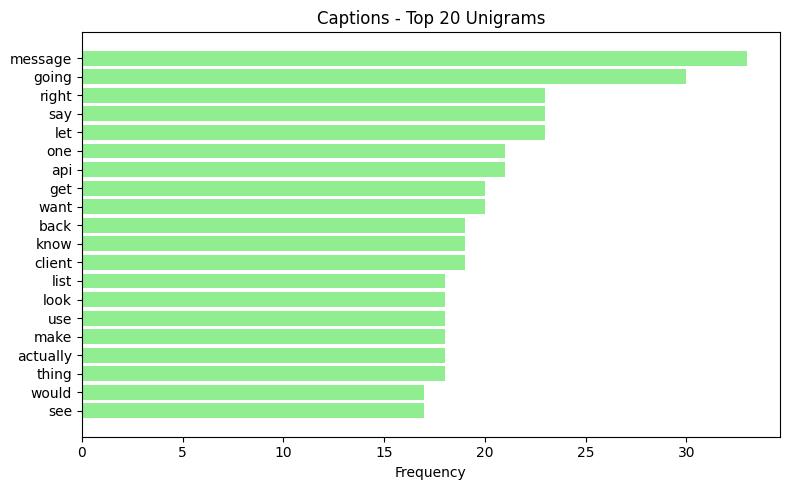

Saved: Lab3_PatternMining_Jaben/captions_top20_unigrams.png


In [11]:
# Tiny helper
def _flatten(list_of_lists):
    return list(itertools.chain.from_iterable(list_of_lists))

def plot_top_pairs_and_unigrams(pairs, tokens_list, title, prefix, color, out_dir="."):
    # Ensure output folder exists
    os.makedirs(out_dir, exist_ok=True)

    # Align token filtering with upstream pair counting (stopwords removed)
    tokens = _flatten(tokens_list)
    tokens = [t for t in tokens if t not in stop_words and isinstance(t, str) and t]

    # Filter stopwords for visualization
    filtered_pairs = [(a, b, n) for (a, b, n) in pairs if a not in stop_words and b not in stop_words]

    # === Top 20 Co-occurring Pairs ===
    top_pairs_for_plot = filtered_pairs[:20]
    pair_labels = [f"{a} / {b}" for a, b, _ in top_pairs_for_plot]
    pair_counts = [c for _, _, c in top_pairs_for_plot]

    plt.figure(figsize=(8, 5))
    plt.barh(pair_labels[::-1], pair_counts[::-1], color=color)
    plt.title(f"{title} - Top 20 Co-occurring Word Pairs")
    plt.xlabel("Co-occurrence Count")
    plt.tight_layout()

    # Save
    out1 = os.path.join(out_dir, f"{prefix}_top20_pairs.png")
    plt.savefig(out1, dpi=200, bbox_inches="tight")
    plt.show()
    plt.close()
    print(f"Saved: {out1}")

    # === Top 20 Unigrams ===
    uni = Counter(tokens).most_common(20)
    if uni:
        uni_labels, uni_counts = zip(*uni)
        plt.figure(figsize=(8, 5))
        plt.barh(list(uni_labels)[::-1], list(uni_counts)[::-1], color=color)
        plt.title(f"{title} - Top 20 Unigrams")
        plt.xlabel("Frequency")
        plt.tight_layout()

        # Save
        out2 = os.path.join(out_dir, f"{prefix}_top20_unigrams.png")
        plt.savefig(out2, dpi=200, bbox_inches="tight")
        plt.show()
        plt.close()
        print(f"Saved: {out2}")


# Save plots to OUT_DIR
df_pairs_comments = plot_top_pairs_and_unigrams(
    pairs_comments, transactions_comments,
    title="Comments",
    prefix="comments",
    color="skyblue",
    out_dir=OUT_DIR
)

df_pairs_captions = plot_top_pairs_and_unigrams(
    pairs_captions, transactions_captions,
    title="Captions",
    prefix="captions",
    color="lightgreen",
    out_dir=OUT_DIR
)

In [12]:
# Export to CSV
df_pairs_comments = pd.DataFrame(pairs_comments, columns=["word1", "word2", "count"])
df_pairs_captions = pd.DataFrame(pairs_captions, columns=["word1", "word2", "count"])

df_pairs_comments.to_csv(os.path.join(OUT_DIR, "comments_cooccurrence_pairs.csv"), index=False)
df_pairs_captions.to_csv(os.path.join(OUT_DIR, "captions_cooccurrence_pairs.csv"), index=False)

print("Saved:")
print("-", os.path.join(OUT_DIR, "comments_cooccurrence_pairs.csv"))
print("-", os.path.join(OUT_DIR, "captions_cooccurrence_pairs.csv"))


Saved:
- Lab3_PatternMining_Jaben/comments_cooccurrence_pairs.csv
- Lab3_PatternMining_Jaben/captions_cooccurrence_pairs.csv


Saved: Lab3_PatternMining_Jaben/comments_-_co-occurrence_network_cooccurrence_network.png


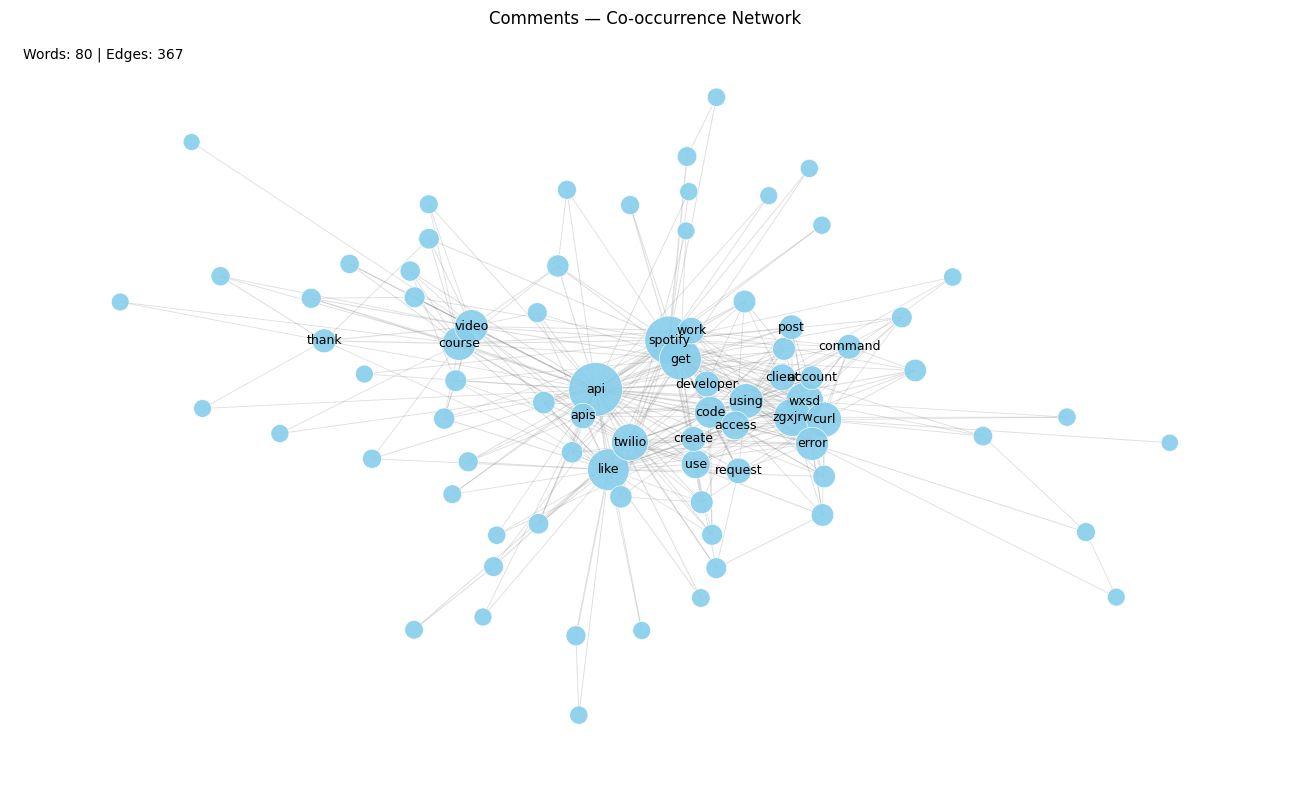

Saved: Lab3_PatternMining_Jaben/captions_-_co-occurrence_network_cooccurrence_network.png


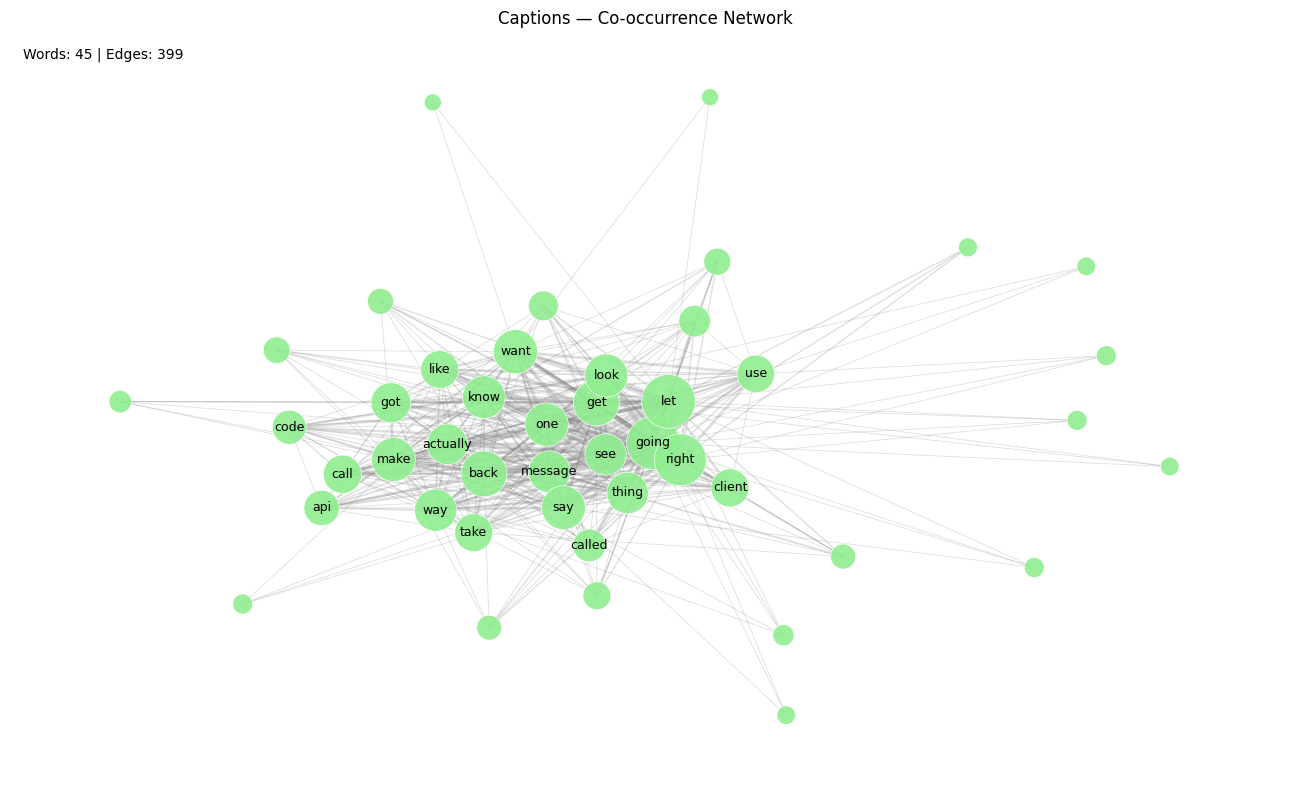

In [13]:
def plot_cooccurrence_network(
    pairs_sorted,
    title,
    color,                    # "skyblue" or "lightgreen"
    min_count=3,              # keep edges with weight >= min_count
    max_edges=400,            # cap strongest edges for clarity
    min_degree=2,             # drop low-degree leaves to reduce clutter (set 1 to keep all)
    label_mode="topk",        # "topk" or "all"
    label_top_k=20,           # used if label_mode="topk"
    ban_tokens=None,          # iterable of tokens to drop entirely
    seed=42
):
    os.makedirs(OUT_DIR, exist_ok=True)  # ensure directory exists

    # Banlist cleanup
    ban = set(ban_tokens or [])
    url_like = lambda w: ("http" in w) or ("www" in w) or (w.endswith((".com", ".net", ".org")))

    # Filter + cap edges
    edges = [(a, b, n) for (a, b, n) in pairs_sorted
             if n >= min_count and a not in ban and b not in ban and not url_like(a) and not url_like(b)]
    if not edges:
        print(f"[{title}] No edges at threshold min_count={min_count}.")
        return
    edges = sorted(edges, key=lambda x: x[2], reverse=True)[:max_edges]

    # Build graph
    G = nx.Graph()
    G.add_weighted_edges_from(edges)

    # Optional prune low-degree nodes
    if min_degree > 1:
        keep = [n for n, d in G.degree() if d >= min_degree]
        G = G.subgraph(keep).copy()
        if G.number_of_edges() == 0:
            print(f"[{title}] All edges removed after min_degree={min_degree}. Try min_degree=1.")
            return

    # Stats
    n_nodes, n_edges = G.number_of_nodes(), G.number_of_edges()
    stats_text = f"Words: {n_nodes} | Edges: {n_edges}"

    # Strength & labels
    strength = dict(G.degree(weight="weight"))
    if label_mode == "all":
        label_nodes = set(G.nodes())
    else:
        label_nodes = set(sorted(strength, key=strength.get, reverse=True)[:min(label_top_k, len(G))])

    # Layout
    pos = nx.spring_layout(G, seed=seed, k=0.75 / (len(G) ** 0.35 + 1e-6), iterations=100)

    # Scaling
    s_vals = list(strength.values())
    s_min, s_max = min(s_vals), max(s_vals)
    node_sizes = [
        150 + (1500 - 150) * ((strength[n] - s_min) / (s_max - s_min + 1e-9))
        for n in G.nodes()
    ]
    w_vals = [d["weight"] for _, _, d in G.edges(data=True)]
    w_min, w_max = min(w_vals), max(w_vals)
    edge_widths = [0.6 + (4.0 - 0.6) * ((w - w_min) / (w_max - w_min + 1e-9)) for w in w_vals]

    # Draw
    plt.figure(figsize=(13, 8))
    nx.draw_networkx_edges(G, pos, width=edge_widths, alpha=0.25, edge_color="gray")
    nx.draw_networkx_nodes(G, pos,
                           node_size=node_sizes, alpha=0.9,
                           node_color=color, linewidths=0.5, edgecolors="white")
    nx.draw_networkx_labels(G, pos, labels={n: n for n in label_nodes}, font_size=9)
    plt.title(title)
    plt.text(0.01, 0.98, stats_text, transform=plt.gca().transAxes,
             va="top", ha="left", fontsize=10)
    plt.axis("off")
    plt.tight_layout()

    # Save
    safe_title = title.lower().replace(" ", "_").replace("—", "-")
    out_path = os.path.join(OUT_DIR, f"{safe_title}_cooccurrence_network.png")
    plt.savefig(out_path, dpi=220, bbox_inches="tight")
    print("Saved:", out_path)

    # Show saved image
    plt.show()
    plt.close()


# Recommended banlist for noise tokens
ban_tokens = {
    "http", "https", "www", "com", "amp", "quot", "href", "watch", "v", "zxjw", "utm",
    "youtu", "youtube", "link", "click", "token", "id"
}

# Plot Network Graphs
plot_cooccurrence_network(
    pairs_comments,
    title="Comments — Co-occurrence Network",
    color="skyblue",
    min_count=3,
    max_edges=400,
    min_degree=2,
    label_mode="topk",
    label_top_k=25,
    ban_tokens=ban_tokens
)

plot_cooccurrence_network(
    pairs_captions,
    title="Captions — Co-occurrence Network",
    color="lightgreen",
    min_count=3,
    max_edges=400,
    min_degree=2,
    label_mode="topk",
    label_top_k=25,
    ban_tokens=ban_tokens
)

In [14]:
# One-hot encode transactions
def to_onehot_df(transactions):
    te = TransactionEncoder()
    arr = te.fit(transactions).transform(transactions)
    return pd.DataFrame(arr, columns=te.columns_).astype(bool)
onehot_comments = to_onehot_df(transactions_comments)
onehot_captions = to_onehot_df(transactions_captions)

print("One-hot shapes:", onehot_comments.shape, onehot_captions.shape)

One-hot shapes: (788, 2382) (52, 1852)


In [15]:
# Apriori runner
def _supp_suffix(s: float) -> str:
    # 0.3 -> 'supp03', 0.15 -> 'supp015', 0.05 -> 'supp005'
    return "supp" + f"{s:.2f}".split(".")[1].ljust(2, "0")

def apriori_pipeline(onehot: pd.DataFrame, label: str,
                     support: float,
                     min_conf: float = 0.6,
                     min_lift: float = 1.2,
                     per_support_top_k: int = 200,
                     max_plot_points: int = 250,
                     do_plot: bool = True):
    os.makedirs(OUT_DIR, exist_ok=True)
    assert 0 < support <= 1.0, "support must be in (0,1]"
    onehot = onehot.astype(bool)
    suff = _supp_suffix(support)

    # Pre-filter single items by support
    item_support = onehot.mean(axis=0).sort_values(ascending=False)
    keep_cols = item_support[item_support >= support].index.tolist()

    fis_path   = os.path.join(OUT_DIR, f"{label}_frequent_itemsets_{suff}.csv")
    rules_path = os.path.join(OUT_DIR, f"{label}_association_rules_{suff}.csv")

    if not keep_cols:
        print(f"[{label}] s={support}: no 1-items meet support. Skipping CSV save.")
        return # Exit function if no 1-items meet support

    # Restrict to top-K items
    if per_support_top_k is not None and len(keep_cols) > per_support_top_k:
        keep_cols = item_support.loc[keep_cols].iloc[:per_support_top_k].index.tolist()
    onehot_s = onehot[keep_cols]

    # Apriori up to length 3
    fis = apriori(onehot_s, min_support=support, use_colnames=True, low_memory=True, max_len=3)

    if fis.empty:
        print(f"[{label}] s={support}: Apriori found no itemsets. Skipping CSV save.")
        return # Exit function if no itemsets found

    fis["length"] = fis["itemsets"].apply(len)
    # Save all frequent itemsets, including length 1, for potential later use
    if not fis.empty and len(fis) > 0: # Explicitly check for non-empty DataFrame with rows
        fis.to_csv(fis_path, index=False)
        print(f"Saved frequent itemsets → {fis_path} (n={len(fis)})")
    else:
        print(f"[{label}] s={support}: No frequent itemsets to save.")


    if fis[fis["length"] >= 2].empty:
        print(f"[{label}] s={support}: only 1-itemsets found ({len(fis)} total). No 2–3 itemsets → no rules. Skipping rules CSV save.")
        return # Exit function if only 1-itemsets found


    # Generate rules from ALL frequent itemsets
    rules = association_rules(fis, metric="confidence", min_threshold=1e-9)


    if rules.empty:
        print(f"[{label}] s={support}: association_rules produced 0 rules. Skipping rules CSV save.")
        return # Exit function if no rules produced

    rules_f = rules[(rules["confidence"] >= min_conf) & (rules["lift"] >= min_lift)].copy()
    if not rules_f.empty and len(rules_f) > 0: # Explicitly check for non-empty DataFrame with rows
        rules_f.to_csv(rules_path, index=False)
        print(f"Saved rules → {rules_path} (n={len(rules_f)})")
    else:
         print(f"[{label}] s={support}: No rules meet min_conf/min_lift. Skipping rules CSV save.")


    # Scatter (support vs confidence)
    if do_plot and not rules_f.empty and len(rules_f) > 0: # Only plot if there are rules to plot
        plot_df = rules_f if len(rules_f) <= max_plot_points else rules_f.sample(n=max_plot_points, random_state=42)
        color = "blue" if label.lower().startswith("comment") else ("green" if label.lower().startswith("caption") else "orange")

        plt.figure(figsize=(6,5))
        plt.scatter(plot_df["support"], plot_df["confidence"], c=color, edgecolors="none")
        plt.title(f"{label} | min_support={support} | support vs confidence")
        plt.xlabel("support")
        plt.ylabel("confidence")
        plt.grid(True)
        plt.tight_layout()
        plot_path = os.path.join(OUT_DIR, f"{label}_support_confidence_{suff}.png")
        plt.savefig(plot_path, dpi=200, bbox_inches="tight")
        plt.show()
        print(f"Saved plot → {plot_path}")

[comments] s=0.3: no 1-items meet support. Skipping CSV save.
[comments] s=0.2: no 1-items meet support. Skipping CSV save.
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_frequent_itemsets_supp15.csv (n=5)
[comments] s=0.15: only 1-itemsets found (5 total). No 2–3 itemsets → no rules. Skipping rules CSV save.
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_frequent_itemsets_supp10.csv (n=133)
Saved rules → Lab3_PatternMining_Jaben/comments_association_rules_supp10.csv (n=576)


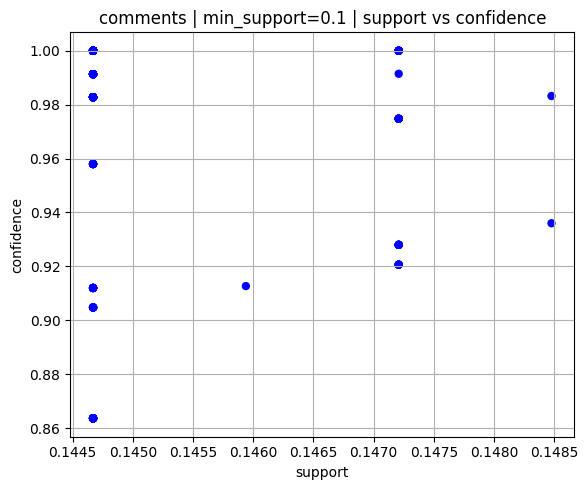

Saved plot → Lab3_PatternMining_Jaben/comments_support_confidence_supp10.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_frequent_itemsets_supp05.csv (n=147)
Saved rules → Lab3_PatternMining_Jaben/comments_association_rules_supp05.csv (n=576)


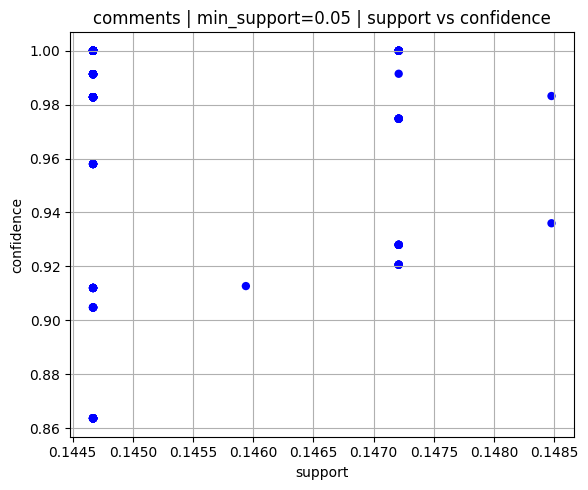

Saved plot → Lab3_PatternMining_Jaben/comments_support_confidence_supp05.png


In [16]:
# Run Apriori pipeline for comments (supports 0.3, 0.2, 0.1, 0.15, 0.05)
apriori_pipeline(onehot_comments, "comments", support=0.30, per_support_top_k=200)
apriori_pipeline(onehot_comments, "comments", support=0.20, per_support_top_k=180)
apriori_pipeline(onehot_comments, "comments", support=0.15, per_support_top_k=200)
apriori_pipeline(onehot_comments, "comments", support=0.10, per_support_top_k=160)
apriori_pipeline(onehot_comments, "comments", support=0.05, per_support_top_k=150)

Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_frequent_itemsets_supp30.csv (n=229)
Saved rules → Lab3_PatternMining_Jaben/captions_association_rules_supp30.csv (n=769)


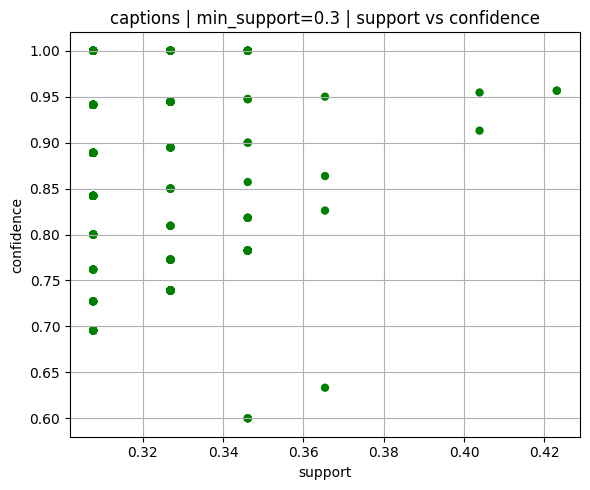

Saved plot → Lab3_PatternMining_Jaben/captions_support_confidence_supp30.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_frequent_itemsets_supp20.csv (n=7805)
Saved rules → Lab3_PatternMining_Jaben/captions_association_rules_supp20.csv (n=36130)


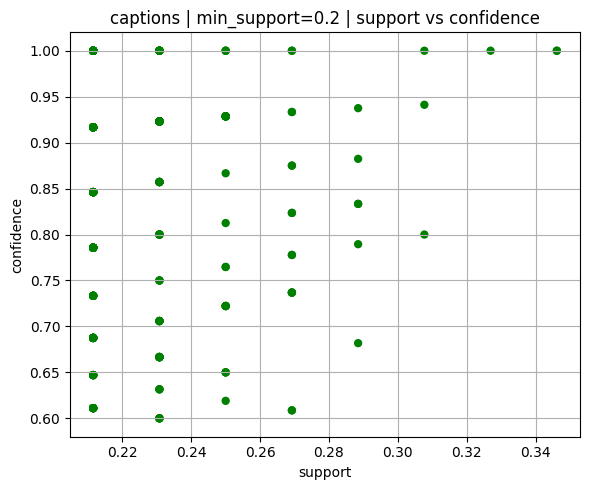

Saved plot → Lab3_PatternMining_Jaben/captions_support_confidence_supp20.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_frequent_itemsets_supp15.csv (n=78701)
Saved rules → Lab3_PatternMining_Jaben/captions_association_rules_supp15.csv (n=341010)


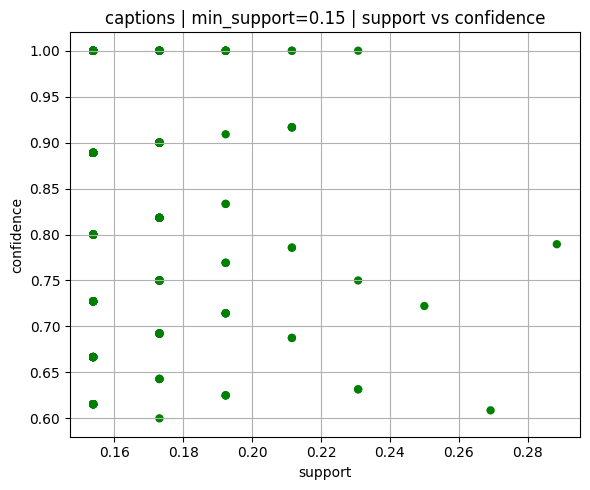

Saved plot → Lab3_PatternMining_Jaben/captions_support_confidence_supp15.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_frequent_itemsets_supp10.csv (n=291822)
Saved rules → Lab3_PatternMining_Jaben/captions_association_rules_supp10.csv (n=1240255)


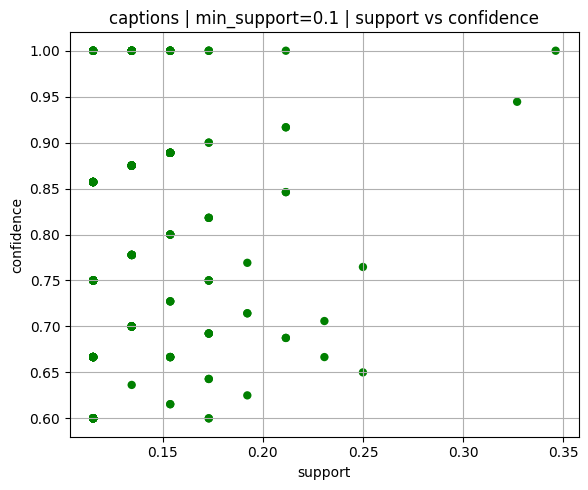

Saved plot → Lab3_PatternMining_Jaben/captions_support_confidence_supp10.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_frequent_itemsets_supp05.csv (n=518023)
Saved rules → Lab3_PatternMining_Jaben/captions_association_rules_supp05.csv (n=1719597)


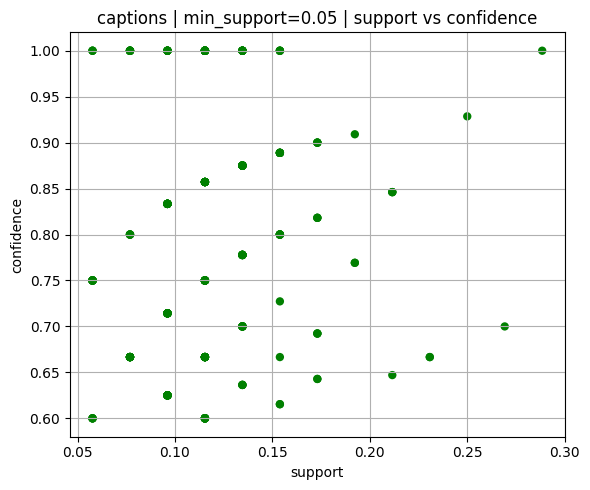

Saved plot → Lab3_PatternMining_Jaben/captions_support_confidence_supp05.png


In [17]:
# Run Apriori pipeline for captions (supports 0.3, 0.2, 0.1, 0.15, 0.05)
apriori_pipeline(onehot_captions, "captions", support=0.30, per_support_top_k=200)
apriori_pipeline(onehot_captions, "captions", support=0.20, per_support_top_k=180)
apriori_pipeline(onehot_captions, "captions", support=0.15, per_support_top_k=200)
apriori_pipeline(onehot_captions, "captions", support=0.10, per_support_top_k=160)
apriori_pipeline(onehot_captions, "captions", support=0.05, per_support_top_k=150)

[captions_stem] running Apriori at support=0.3
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_stem_frequent_itemsets_supp30.csv (n=342)
Saved rules → Lab3_PatternMining_Jaben/captions_stem_association_rules_supp30.csv (n=1290)


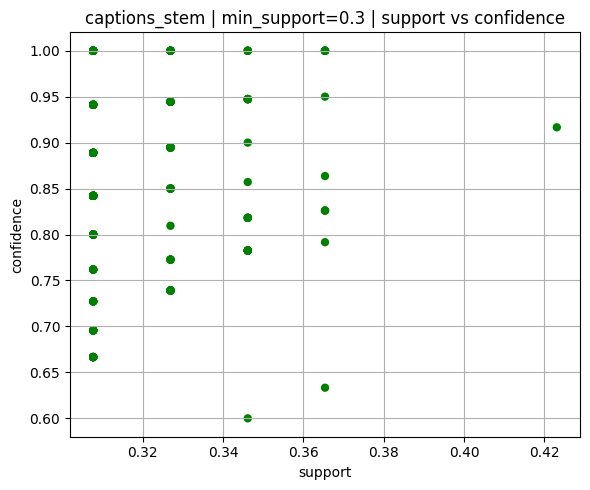

Saved plot → Lab3_PatternMining_Jaben/captions_stem_support_confidence_supp30.png
[captions_stem] running Apriori at support=0.2
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_stem_frequent_itemsets_supp20.csv (n=9954)
Saved rules → Lab3_PatternMining_Jaben/captions_stem_association_rules_supp20.csv (n=45508)


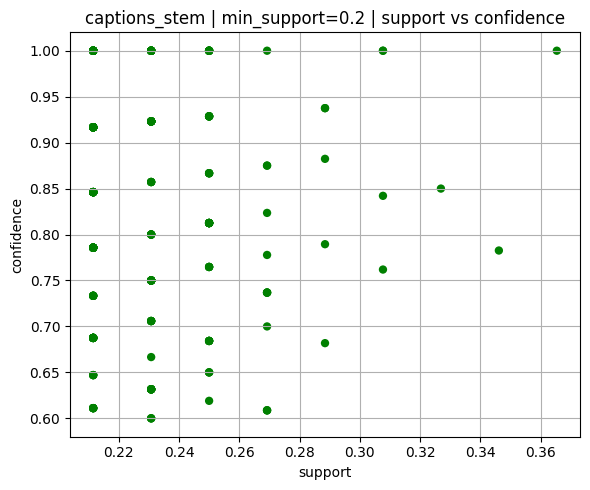

Saved plot → Lab3_PatternMining_Jaben/captions_stem_support_confidence_supp20.png
[captions_stem] running Apriori at support=0.15
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_stem_frequent_itemsets_supp15.csv (n=88083)
Saved rules → Lab3_PatternMining_Jaben/captions_stem_association_rules_supp15.csv (n=379412)


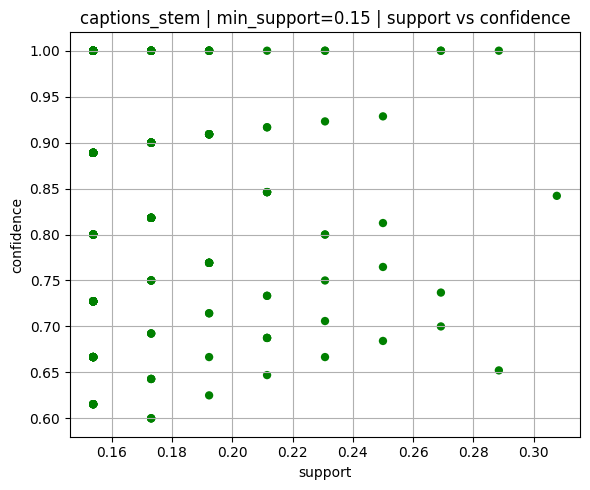

Saved plot → Lab3_PatternMining_Jaben/captions_stem_support_confidence_supp15.png
[captions_stem] running Apriori at support=0.1
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_stem_frequent_itemsets_supp10.csv (n=405735)
Saved rules → Lab3_PatternMining_Jaben/captions_stem_association_rules_supp10.csv (n=1717228)


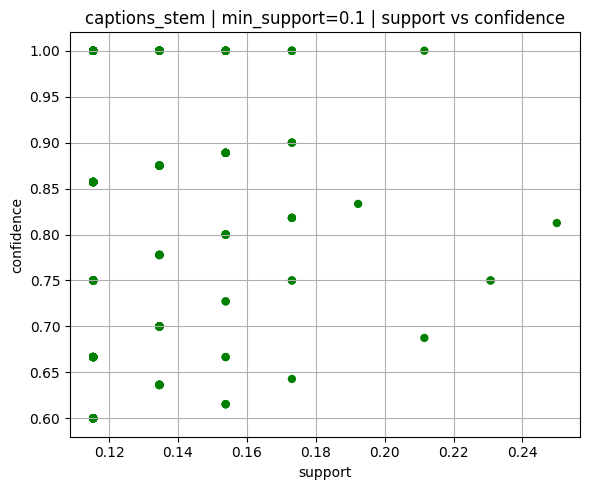

Saved plot → Lab3_PatternMining_Jaben/captions_stem_support_confidence_supp10.png
[captions_stem] running Apriori at support=0.05
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_stem_frequent_itemsets_supp05.csv (n=1153318)
Saved rules → Lab3_PatternMining_Jaben/captions_stem_association_rules_supp05.csv (n=3727735)


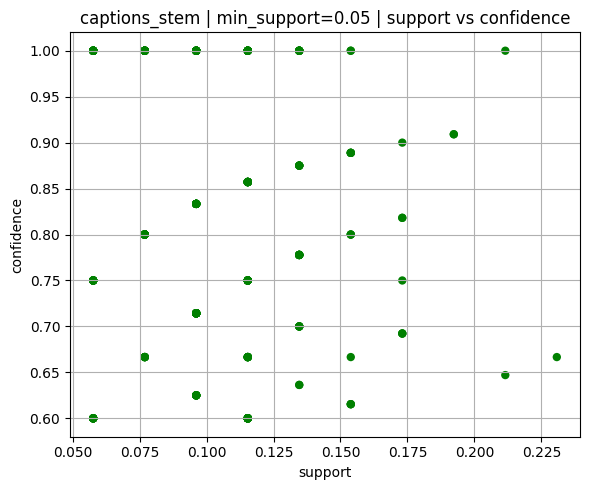

Saved plot → Lab3_PatternMining_Jaben/captions_stem_support_confidence_supp05.png
[comments_stem] running Apriori at support=0.1
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_stem_frequent_itemsets_supp10.csv (n=136)
Saved rules → Lab3_PatternMining_Jaben/comments_stem_association_rules_supp10.csv (n=576)


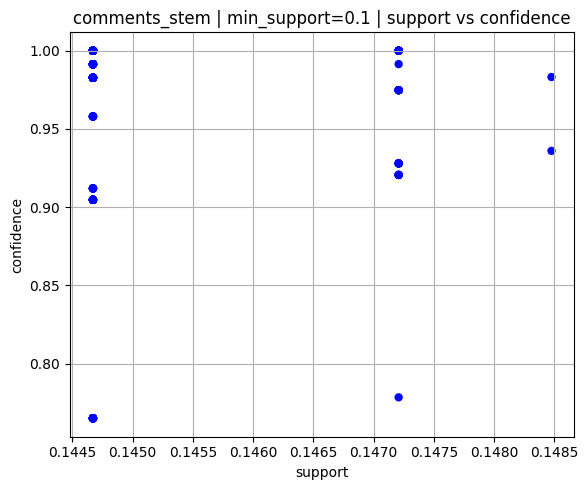

Saved plot → Lab3_PatternMining_Jaben/comments_stem_support_confidence_supp10.png
[comments_stem] running Apriori at support=0.15
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_stem_frequent_itemsets_supp15.csv (n=5)
[comments_stem] s=0.15: only 1-itemsets found (5 total). No 2–3 itemsets → no rules. Skipping rules CSV save.
[comments_stem] running Apriori at support=0.05
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_stem_frequent_itemsets_supp05.csv (n=149)
Saved rules → Lab3_PatternMining_Jaben/comments_stem_association_rules_supp05.csv (n=576)


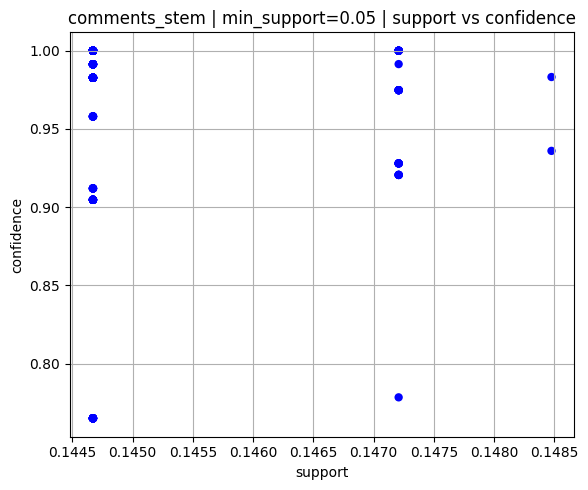

Saved plot → Lab3_PatternMining_Jaben/comments_stem_support_confidence_supp05.png


In [18]:
# Stemming
ps = PorterStemmer()

def stem_tokens_list(tokens_list):
    return [ps.stem(t) for t in tokens_list if isinstance(t, str)]

comments_stem = comments.copy()
captions_stem = captions.copy()
comments_stem['cleaned_tokens'] = comments_stem['cleaned_tokens'].apply(stem_tokens_list)
captions_stem['cleaned_tokens'] = captions_stem['cleaned_tokens'].apply(stem_tokens_list)

transactions_comments_stem, _ = make_transactions(comments_stem,  min_len=3, dedup=True)
transactions_captions_stem, _ = make_transactions(captions_stem,  min_len=3, dedup=True)

onehot_comments_stem = to_onehot_df(transactions_comments_stem)
onehot_captions_stem = to_onehot_df(transactions_captions_stem)

# Run Apriori for all supports
captions_supports = [0.30, 0.20, 0.15, 0.10, 0.05]
comments_supports = [0.10, 0.15, 0.05]

for s in captions_supports:
    print(f"[captions_stem] running Apriori at support={s}")
    apriori_pipeline(onehot_captions_stem, "captions_stem", support=s, per_support_top_k=200)

for s in comments_supports:
    print(f"[comments_stem] running Apriori at support={s}")
    apriori_pipeline(onehot_comments_stem, "comments_stem", support=s, per_support_top_k=200)

[captions_len4] Apriori at support=0.3
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp30.csv (n=560)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp30.csv (n=2096)


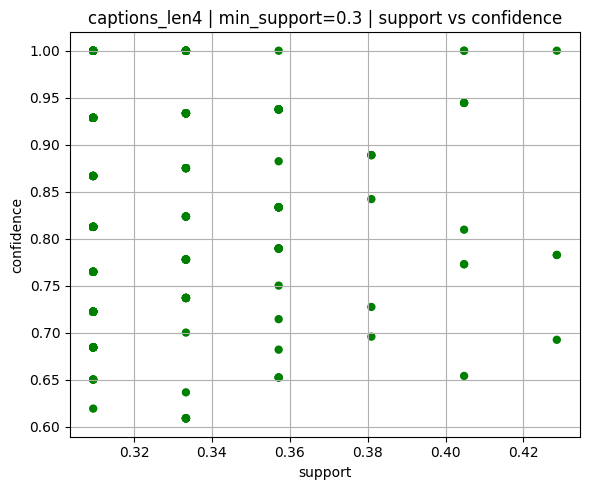

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp30.png
[captions_len4] Apriori at support=0.2
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp20.csv (n=14320)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp20.csv (n=59652)


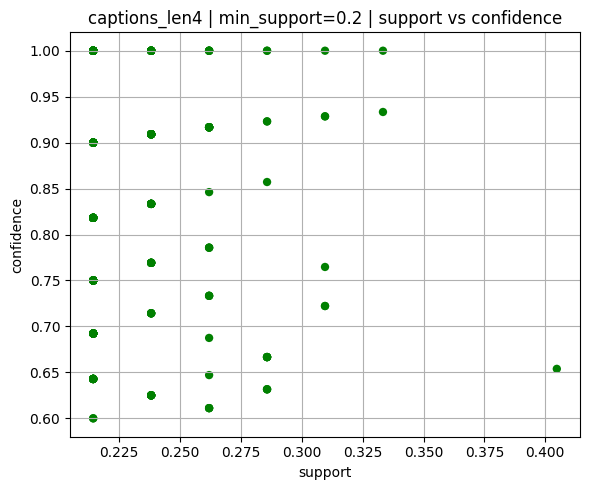

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp20.png
[captions_len4] Apriori at support=0.15
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp15.csv (n=95629)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp15.csv (n=403577)


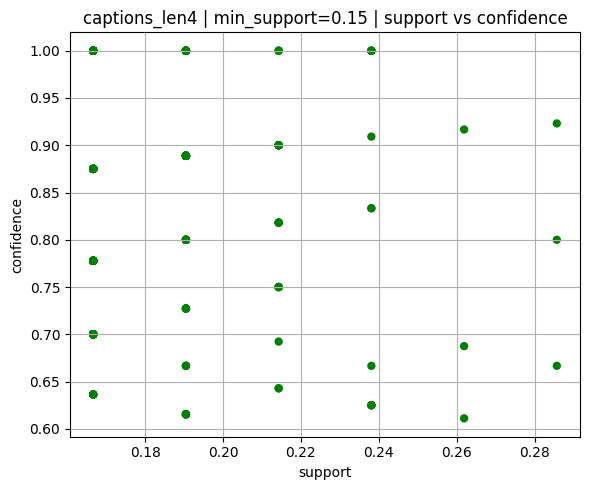

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp15.png
[captions_len4] Apriori at support=0.1
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp10.csv (n=485273)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp10.csv (n=1975407)


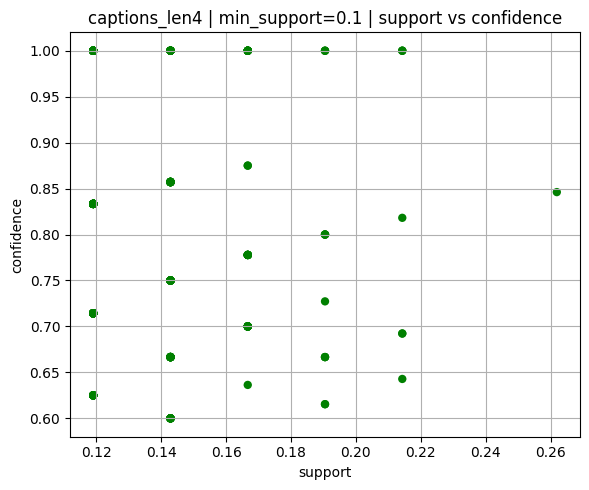

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp10.png
[captions_len4] Apriori at support=0.05
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp05.csv (n=1058264)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp05.csv (n=3456036)


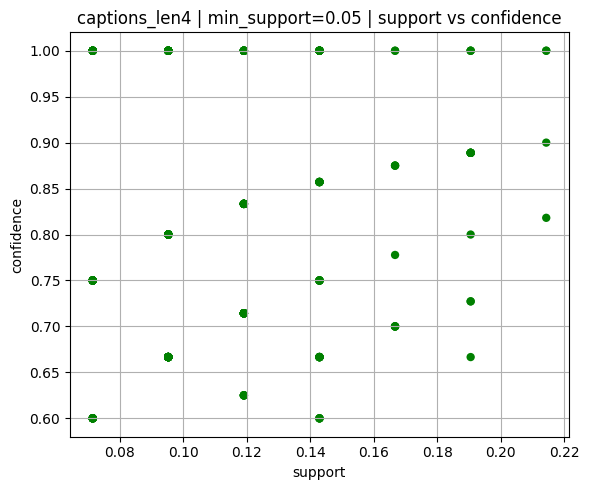

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp05.png
[comments_len4] Apriori at support=0.1
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_len4_frequent_itemsets_supp10.csv (n=45)
Saved rules → Lab3_PatternMining_Jaben/comments_len4_association_rules_supp10.csv (n=150)


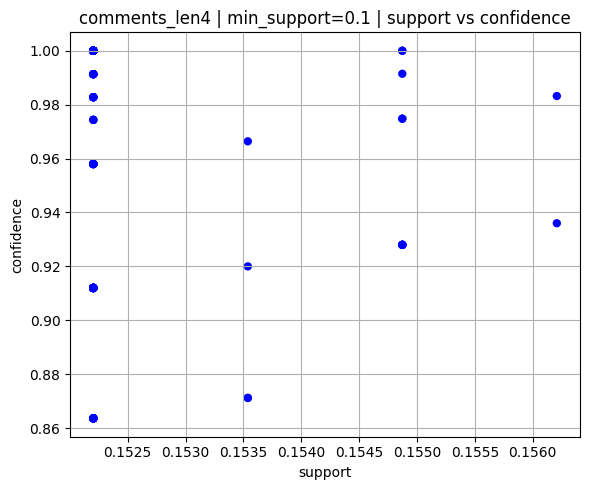

Saved plot → Lab3_PatternMining_Jaben/comments_len4_support_confidence_supp10.png
[comments_len4] Apriori at support=0.15
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_len4_frequent_itemsets_supp15.csv (n=41)
Saved rules → Lab3_PatternMining_Jaben/comments_len4_association_rules_supp15.csv (n=150)


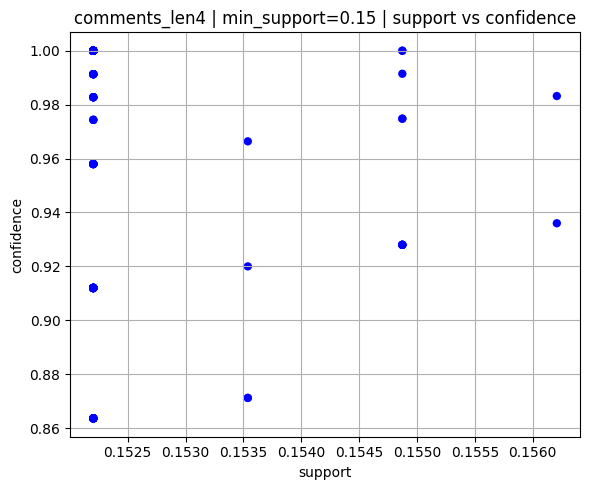

Saved plot → Lab3_PatternMining_Jaben/comments_len4_support_confidence_supp15.png
[comments_len4] Apriori at support=0.05
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_len4_frequent_itemsets_supp05.csv (n=58)
Saved rules → Lab3_PatternMining_Jaben/comments_len4_association_rules_supp05.csv (n=150)


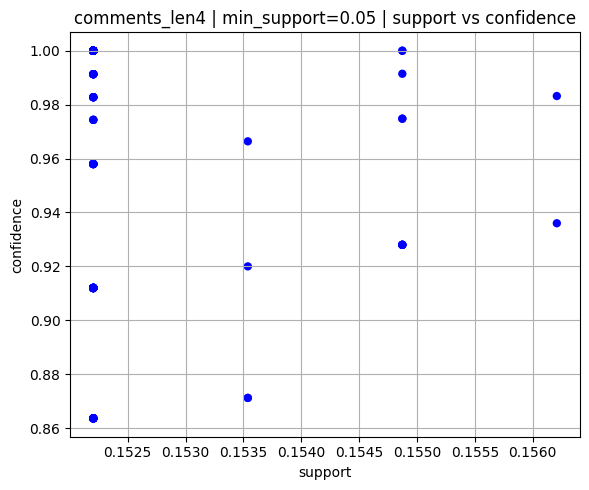

Saved plot → Lab3_PatternMining_Jaben/comments_len4_support_confidence_supp05.png


In [19]:
# Remove tokens under 4 characters, rebuild transactions/one-hot, rerun Apriori (0.3)
def filter_min_chars(df, min_chars=4):
    df2 = df.copy()
    df2['cleaned_tokens'] = df2['cleaned_tokens'].apply(
        lambda toks: [t for t in toks if isinstance(t, str) and len(t) >= min_chars]
    )
    return df2

comments_len4 = filter_min_chars(comments, min_chars=4)
captions_len4 = filter_min_chars(captions, min_chars=4)

# Transactions (len>=3)
transactions_comments_len4, _ = make_transactions(comments_len4,  min_len=3, dedup=True)
transactions_captions_len4, _ = make_transactions(captions_len4,  min_len=3, dedup=True)

onehot_comments_len4 = to_onehot_df(transactions_comments_len4)
onehot_captions_len4 = to_onehot_df(transactions_captions_len4)

# Run Apriori for all supports
captions_supports = [0.30, 0.20, 0.15, 0.10, 0.05]
comments_supports = [0.10, 0.15, 0.05]

for s in captions_supports:
    print(f"[captions_len4] Apriori at support={s}")
    apriori_pipeline(onehot_captions_len4, "captions_len4", support=s, per_support_top_k=200)

for s in comments_supports:
    print(f"[comments_len4] Apriori at support={s}")
    apriori_pipeline(onehot_comments_len4, "comments_len4", support=s, per_support_top_k=200)

Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp20.csv (n=14320)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp20.csv (n=59652)


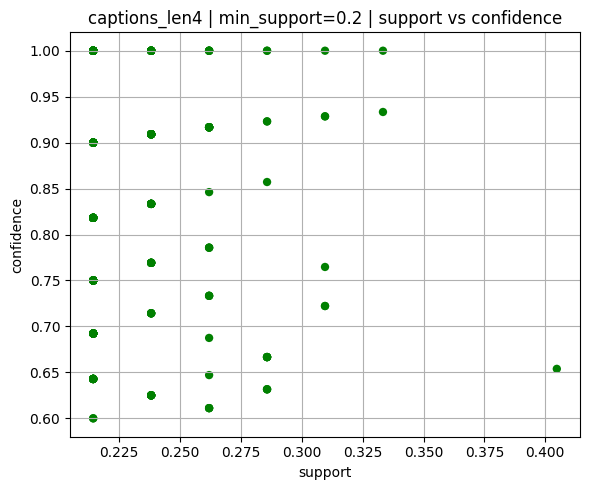

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp20.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp10.csv (n=348392)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp10.csv (n=1400129)


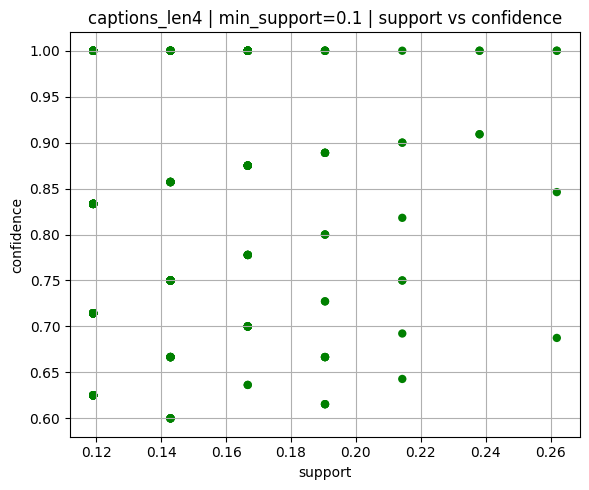

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp10.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp15.csv (n=95629)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp15.csv (n=403577)


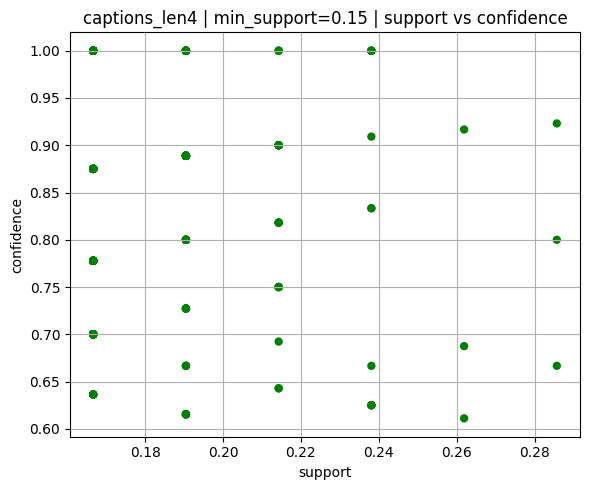

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp15.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/captions_len4_frequent_itemsets_supp05.csv (n=415018)
Saved rules → Lab3_PatternMining_Jaben/captions_len4_association_rules_supp05.csv (n=1384175)


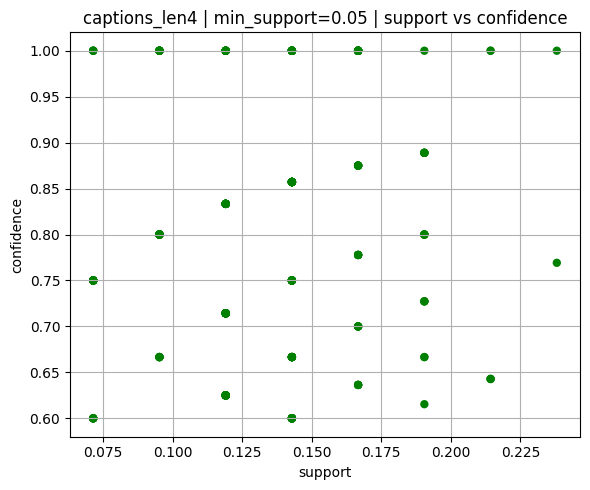

Saved plot → Lab3_PatternMining_Jaben/captions_len4_support_confidence_supp05.png


In [20]:
# len>=4

# captions_len4
apriori_pipeline(onehot_captions_len4, "captions_len4", support=0.20, per_support_top_k=180)
apriori_pipeline(onehot_captions_len4, "captions_len4", support=0.10, per_support_top_k=160)
apriori_pipeline(onehot_captions_len4, "captions_len4", support=0.15, per_support_top_k=180)
apriori_pipeline(onehot_captions_len4, "captions_len4", support=0.05, per_support_top_k=140)

[comments_len4] s=0.2: no 1-items meet support. Skipping CSV save.
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_len4_frequent_itemsets_supp10.csv (n=45)
Saved rules → Lab3_PatternMining_Jaben/comments_len4_association_rules_supp10.csv (n=150)


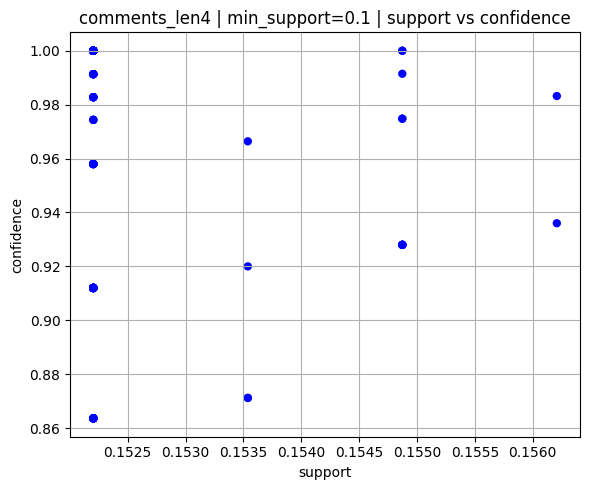

Saved plot → Lab3_PatternMining_Jaben/comments_len4_support_confidence_supp10.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_len4_frequent_itemsets_supp15.csv (n=41)
Saved rules → Lab3_PatternMining_Jaben/comments_len4_association_rules_supp15.csv (n=150)


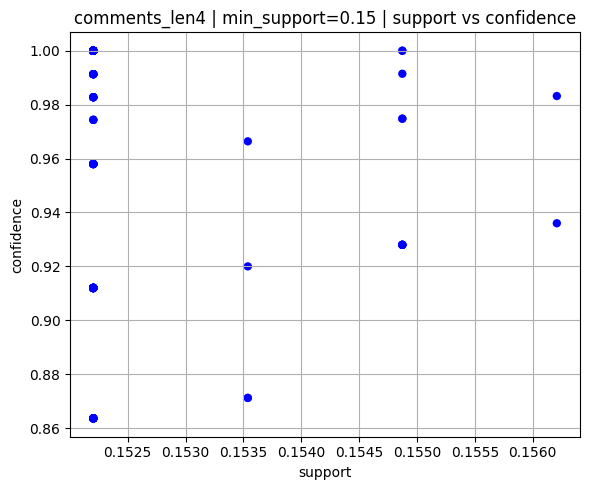

Saved plot → Lab3_PatternMining_Jaben/comments_len4_support_confidence_supp15.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/comments_len4_frequent_itemsets_supp05.csv (n=58)
Saved rules → Lab3_PatternMining_Jaben/comments_len4_association_rules_supp05.csv (n=150)


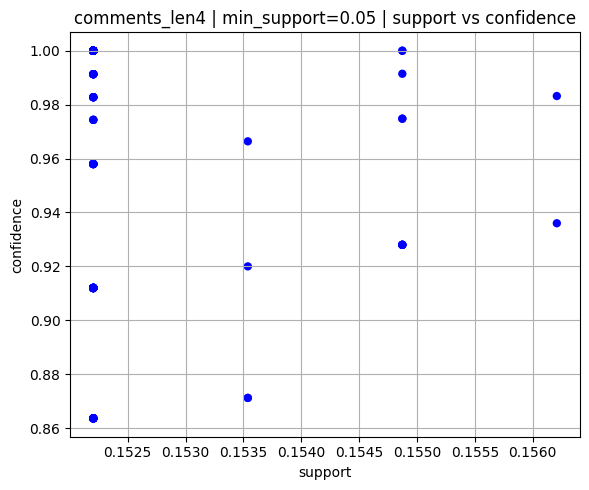

Saved plot → Lab3_PatternMining_Jaben/comments_len4_support_confidence_supp05.png


In [21]:
# len>=4

# comments_len4
apriori_pipeline(onehot_comments_len4, "comments_len4", support=0.20, per_support_top_k=180)
apriori_pipeline(onehot_comments_len4, "comments_len4", support=0.10, per_support_top_k=160)
apriori_pipeline(onehot_comments_len4, "comments_len4", support=0.15, per_support_top_k=180)
apriori_pipeline(onehot_comments_len4, "comments_len4", support=0.05, per_support_top_k=140)

[merged] s=0.3: no 1-items meet support. Skipping CSV save.
[merged] s=0.2: no 1-items meet support. Skipping CSV save.
Saved frequent itemsets → Lab3_PatternMining_Jaben/merged_frequent_itemsets_supp10.csv (n=135)
Saved rules → Lab3_PatternMining_Jaben/merged_association_rules_supp10.csv (n=576)


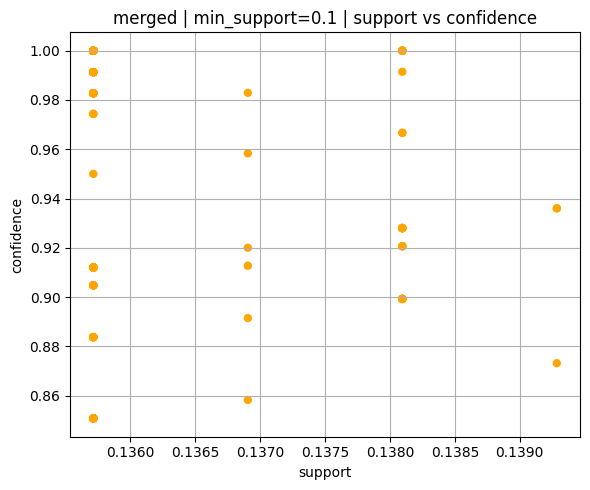

Saved plot → Lab3_PatternMining_Jaben/merged_support_confidence_supp10.png
Saved frequent itemsets → Lab3_PatternMining_Jaben/merged_frequent_itemsets_supp15.csv (n=4)
[merged] s=0.15: only 1-itemsets found (4 total). No 2–3 itemsets → no rules. Skipping rules CSV save.
Saved frequent itemsets → Lab3_PatternMining_Jaben/merged_frequent_itemsets_supp05.csv (n=162)
Saved rules → Lab3_PatternMining_Jaben/merged_association_rules_supp05.csv (n=576)


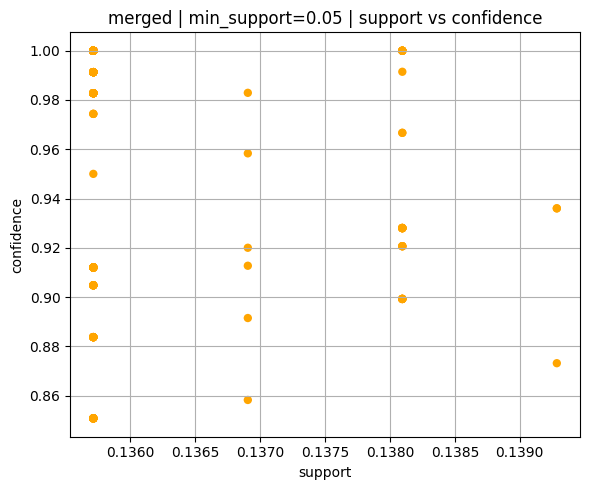

Saved plot → Lab3_PatternMining_Jaben/merged_support_confidence_supp05.png


In [22]:
# Merge comments + captions, create one-hot, rerun Apriori (0.3, 0.2, 0.1, 0,15, 0.05)
transactions_merged = transactions_comments + transactions_captions
onehot_merged = to_onehot_df(transactions_merged)

apriori_pipeline(onehot_merged, "merged", support=0.30, per_support_top_k=220)
apriori_pipeline(onehot_merged, "merged", support=0.20, per_support_top_k=200)
apriori_pipeline(onehot_merged, "merged", support=0.10, per_support_top_k=180)
apriori_pipeline(onehot_merged, "merged", support=0.15, per_support_top_k=220)
apriori_pipeline(onehot_merged, "merged", support=0.05, per_support_top_k=180)

In [23]:
# HELPERS
SUPP = {"0.30":"supp30","0.20":"supp20","0.10":"supp10","0.15":"supp15","0.05":"supp05"}

def _parse_fs(txt: str):
    """Convert "frozenset({'a','b'})" -> ('a','b') safely."""
    if not isinstance(txt, str) or not txt.strip():
        return tuple()
    s = (txt.replace("frozenset({","").replace("})","")
           .replace("{","").replace("}",""))
    parts = [p.strip().strip("'").strip('"') for p in s.split(",") if p.strip()]
    return tuple(sorted(parts))

def _path(fname: str):
    """Read from the same OUT_DIR your pipeline used."""
    return os.path.join(OUT_DIR, fname)

# RULE LOADERS
def read_rules_safe(path: str) -> set:
    """
    Returns set of (antecedents_tuple, consequents_tuple).
    Works for columns ['antecedents','consequents'] or ['antecedents_str','consequents_str'].
    Gracefully returns empty set if file missing/empty.
    """
    if not os.path.exists(path) or os.path.getsize(path) == 0:
        # print(f"File missing or empty: {path}") # Removed debugging print
        return set()
    try:
        df = pd.read_csv(path)
        # print(f"Successfully read file: {path}. Shape: {df.shape}") # Removed debugging print
    except Exception as e:
        print(f"Error reading file {path}: {e}")
        return set()
    if df.empty:
        # print(f"DataFrame is empty after reading: {path}") # Removed debugging print
        return set()

    if {"antecedents","consequents"}.issubset(df.columns):
        ante_col, cons_col = "antecedents", "consequents"
    elif {"antecedents_str","consequents_str"}.issubset(df.columns):
        ante_col, cons_col = "antecedents_str", "consequents_str"
    else:
        print(f"Warning: Unexpected columns in rules file {path}")
        return set()

    # Removed debugging print statements for parsing
    ante = df[ante_col].apply(_parse_fs)
    cons = df[cons_col].apply(_parse_fs)

    rules_set = set(zip(ante, cons))
    return rules_set

def load_itemsets(label: str, supp_key: str) -> pd.DataFrame:
    """Load frequent itemsets CSV written by the pipeline, add parsed tuples."""
    supp_suffix = SUPP[supp_key]
    pattern = _path(f"{label}_frequent_itemsets_{supp_suffix}.csv")
    paths = glob.glob(pattern)
    if not paths:
        # print(f"No itemsets file found for {label} at {supp_key}") # Removed debugging print
        return pd.DataFrame(columns=["itemsets","support","length","itemsets_parsed"])
    df = pd.read_csv(paths[0])
    if "itemsets" in df.columns:
        df["itemsets_parsed"] = df["itemsets"].apply(_parse_fs)
    return df

# COMPARISON: MERGED vs SEPARATE
rules_capt   = read_rules_safe(_path("captions_association_rules_supp03.csv"))  # captions @0.30
rules_comm   = read_rules_safe(_path("comments_association_rules_supp10.csv"))  # comments @0.10 (Corrected filename)
rules_merged = read_rules_safe(_path("merged_association_rules_supp03.csv"))    # merged   @0.30

only_merged = rules_merged - (rules_capt | rules_comm)
only_capt   = rules_capt   - (rules_comm | rules_merged)
only_comm   = rules_comm   - (rules_capt | rules_merged)
common_all  = rules_merged & rules_capt & rules_comm

print("Rules only in merged:", len(only_merged))
print("Rules only in captions:", len(only_capt))
print("Rules only in comments:", len(only_comm))
print("Rules common across all three:", len(common_all))

Rules only in merged: 0
Rules only in captions: 0
Rules only in comments: 576
Rules common across all three: 0


In [24]:
# Top 10 2-itemsets by support
def _color_for(label: str):
    """Helper to return color based on label."""
    if label.lower().startswith("comment"):
        return "skyblue"
    elif label.lower().startswith("caption"):
        return "lightgreen"
    elif label.lower().startswith("merged"):
        return "orange"
    else:
        return "gray"

def plot_topN_itemsets(label: str, supp_key="0.30", length=2, metric="support", topN=10):
    supp = SUPP[supp_key]
    fis = load_itemsets(label, supp_key)
    if fis.empty:
        print(f"[{label}] No itemsets at {supp_key}")
        return
    top = fis[fis["length"]==length].sort_values(metric, ascending=False).head(topN).copy()
    if top.empty:
        print(f"[{label}] No {length}-itemsets at {supp_key}")
        return
    top["label"] = top["itemsets_parsed"].apply(lambda t: " & ".join(t))
    plt.figure(figsize=(8,5))
    plt.barh(top["label"][::-1], top[metric][::-1], color=_color_for(label))
    plt.xlabel(metric.capitalize())
    plt.title(f"{label} | Top {topN} {length}-itemsets by {metric} ({supp_key})")
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"{label}_top{length}itemsets_{metric}_{supp}.png")
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.show()
    print("Saved:", out)

# Top 10 3-itemsets by confidence
def plot_top3_confidence(label: str, supp_key="0.30", topN=10):
    supp = SUPP[supp_key]
    rules = load_rules(label, supp) # Pass the support suffix here
    if rules.empty:
        print(f"[{label}] No rules at {supp_key}")
        return
    rules["rule_label"] = rules.apply(
        lambda r: " & ".join(r["ante_parsed"]) + " → " + " & ".join(r["cons_parsed"]), axis=1)
    top = rules.sort_values("confidence", ascending=False).head(topN)
    plt.figure(figsize=(8,5))
    plt.barh(top["rule_label"][::-1], top["confidence"][::-1], color=_color_for(label))
    plt.xlabel("Confidence")
    plt.title(f"{label} | Top {topN} Rules by Confidence ({supp_key})")
    plt.tight_layout()
    out = os.path.join(OUT_DIR, f"{label}_top3itemsets_confidence_{supp}.png")
    plt.savefig(out, dpi=200, bbox_inches="tight"); plt.show()
    print("Saved:", out)

# Word Cloud from Most Frequent Items
def wordcloud_from_onehot(onehot_df, label: str, top_n=300):
    freqs = onehot_df.astype(bool).mean(axis=0).sort_values(ascending=False).head(top_n)
    wc = WordCloud(width=1000, height=600, background_color="white")
    img = wc.generate_from_frequencies(freqs.to_dict())
    plt.figure(figsize=(10,6))
    plt.imshow(img)
    plt.axis("off")
    plt.title(f"{label} | Word Cloud of Most Frequent Tokens")
    out = os.path.join(OUT_DIR, f"{label}_wordcloud.png")
    plt.savefig(out, dpi=220, bbox_inches="tight"); plt.show()
    print("Saved:", out)

# Cluster Graph of Word Associations
def graph_from_rules(label: str, supp_key="0.30", top_edges=40):
    supp = SUPP[supp_key]
    rules = load_rules(label, supp) # Pass the support suffix here
    if rules.empty:
        print(f"[{label}] No rules at {supp_key}")
        return
    rr = rules.sort_values("lift", ascending=False).head(top_edges).copy()
    G = nx.Graph()
    for _, r in rr.iterrows():
        for a in r["ante_parsed"]:
            for c in r["cons_parsed"]:
                w = float(r["lift"])
                G.add_edge(a, c, weight=w)

    pos = nx.spring_layout(G, seed=42, k=0.7)
    plt.figure(figsize=(10,8))
    widths = [2 * G[u][v]['weight'] for u, v in G.edges()]
    node_color = "lightgreen" if label.lower().startswith("captions") else "#89CFF0"
    nx.draw_networkx_nodes(G, pos, node_color=node_color, node_size=700)
    nx.draw_networkx_edges(G, pos, width=widths, alpha=0.7)
    nx.draw_networkx_labels(G, pos, font_size=9)
    plt.axis("off")
    plt.title(f"{label} | Association Graph (Top {top_edges} by Lift, {supp_key})")
    out = os.path.join(OUT_DIR, f"{label}_assoc_graph_{supp}.png")
    plt.savefig(out, dpi=220, bbox_inches="tight"); plt.show()
    print("Saved:", out)

# Helper to load rules with parsed itemsets
def load_rules(label: str, supp_suffix: str) -> pd.DataFrame:
    """Load association rules CSV written by the pipeline, add parsed tuples."""
    pattern = os.path.join(OUT_DIR, f"{label}_association_rules_{supp_suffix}.csv")
    paths = glob.glob(pattern)
    if not paths or not os.path.exists(paths[0]) or os.path.getsize(paths[0]) == 0:
        return pd.DataFrame() # Return empty DataFrame if file is missing or empty

    try:
        df = pd.read_csv(paths[0])
        if df.empty:
            return pd.DataFrame() # Return empty DataFrame if file is empty after reading
    except pd.errors.EmptyDataError:
        return pd.DataFrame() # Catch EmptyDataError and return empty DataFrame
    except Exception as e:
        print(f"Error reading rules file {paths[0]}: {e}")
        return pd.DataFrame() # Catch any other exceptions and return empty DataFrame

    if {"antecedents","consequents"}.issubset(df.columns):
        df["ante_parsed"] = df["antecedents"].apply(_parse_fs)
        df["cons_parsed"] = df["consequents"].apply(_parse_fs)
    elif {"antecedents_str","consequents_str"}.issubset(df.columns):
         df["ante_parsed"] = df["antecedents_str"].apply(_parse_fs)
         df["cons_parsed"] = df["consequents_str"].apply(_parse_fs)
    else:
        print(f"Warning: Unexpected columns in rules file {paths[0]}")
        return pd.DataFrame() # Return empty DataFrame if columns are unexpected

    return df


Processing CAPTIONS


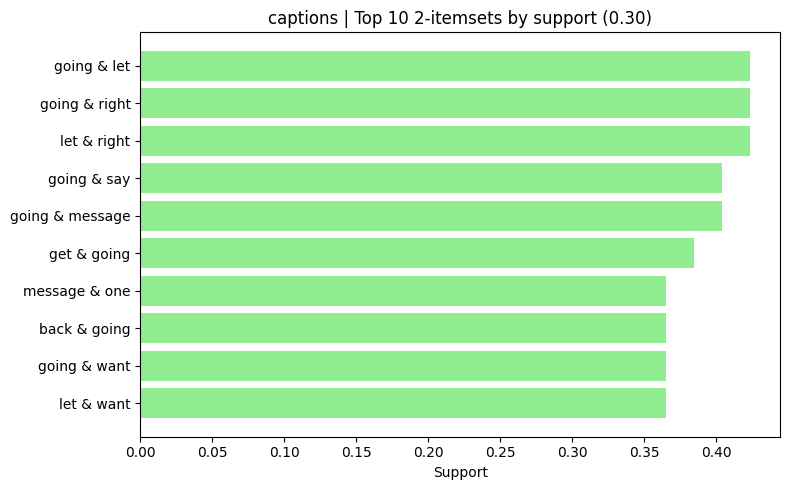

Saved: Lab3_PatternMining_Jaben/captions_top2itemsets_support_supp30.png


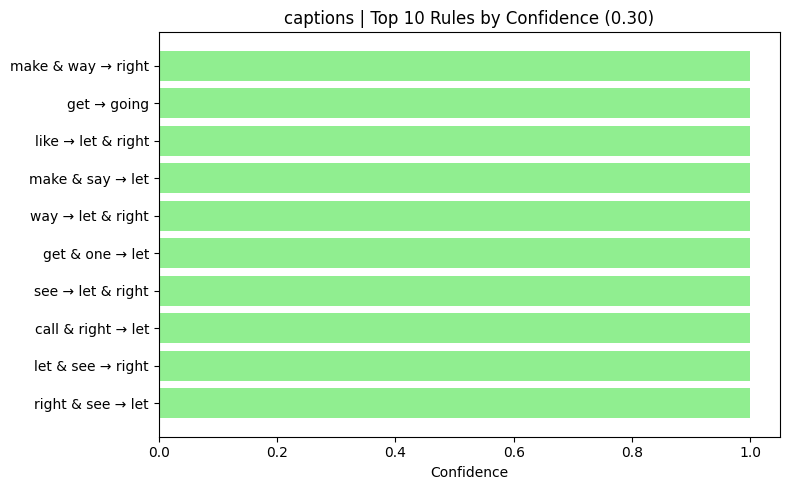

Saved: Lab3_PatternMining_Jaben/captions_top3itemsets_confidence_supp30.png


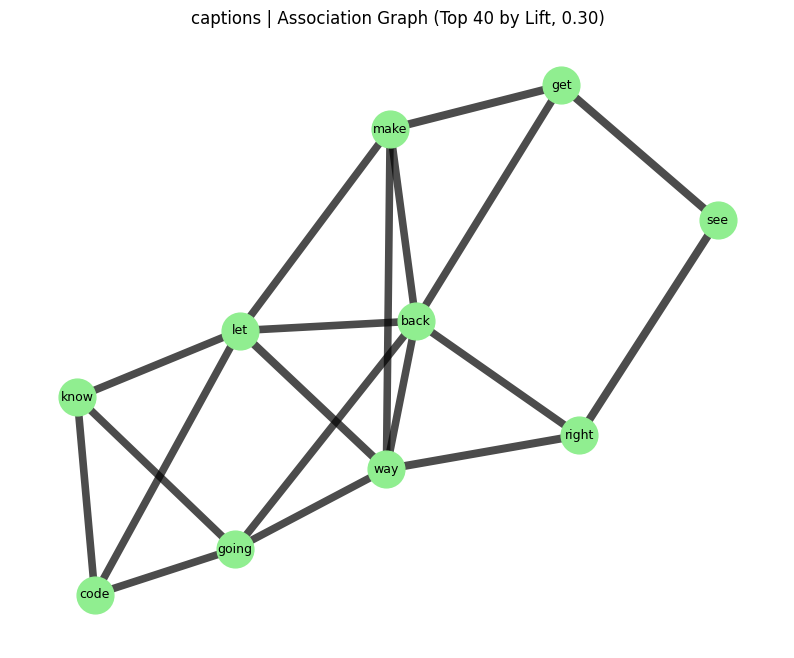

Saved: Lab3_PatternMining_Jaben/captions_assoc_graph_supp30.png


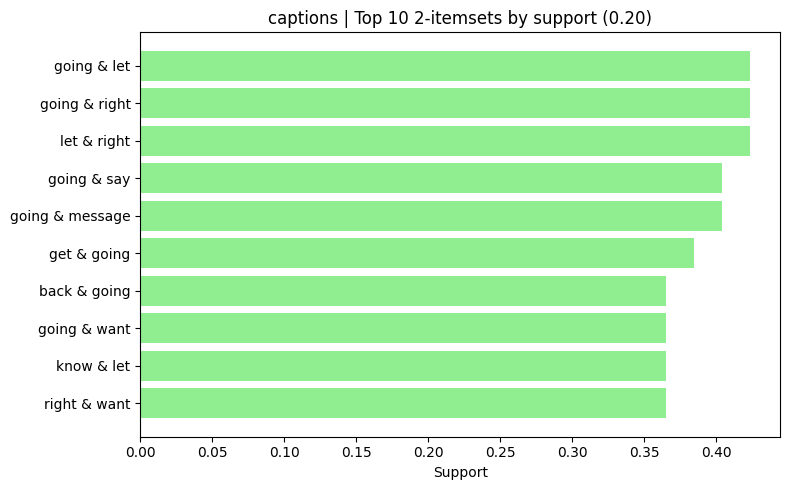

Saved: Lab3_PatternMining_Jaben/captions_top2itemsets_support_supp20.png


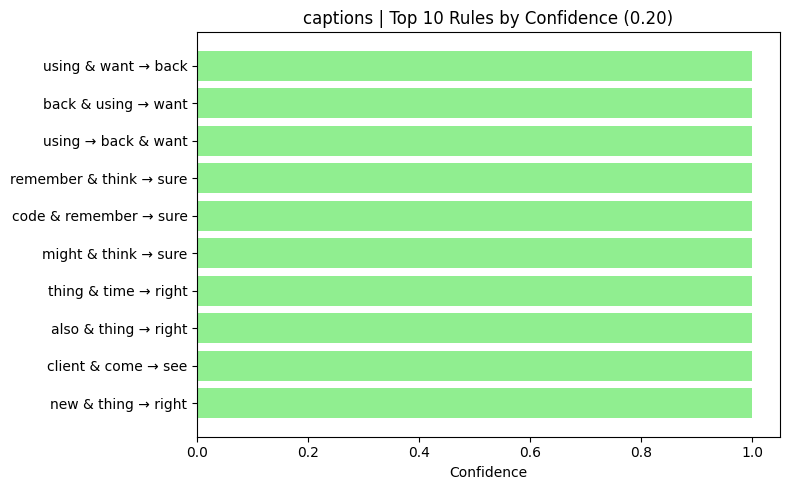

Saved: Lab3_PatternMining_Jaben/captions_top3itemsets_confidence_supp20.png


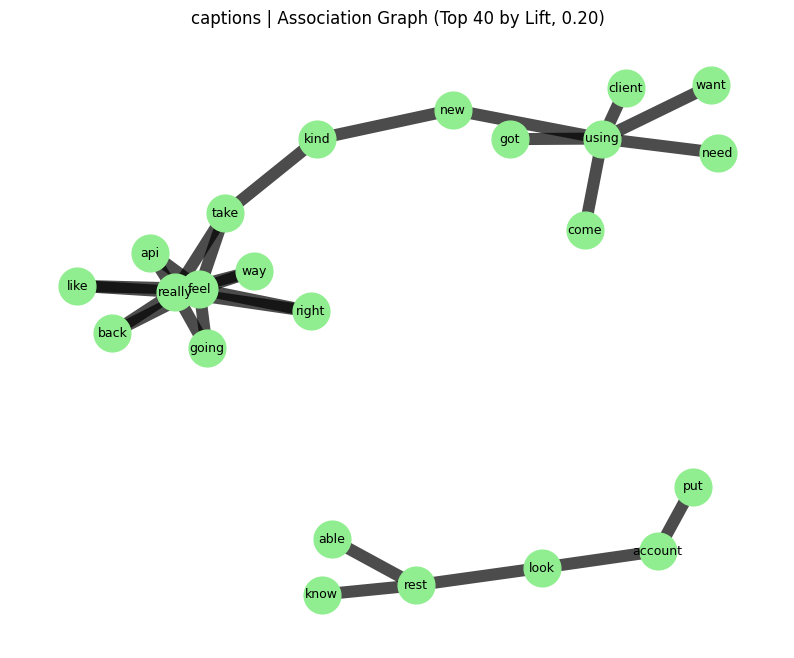

Saved: Lab3_PatternMining_Jaben/captions_assoc_graph_supp20.png


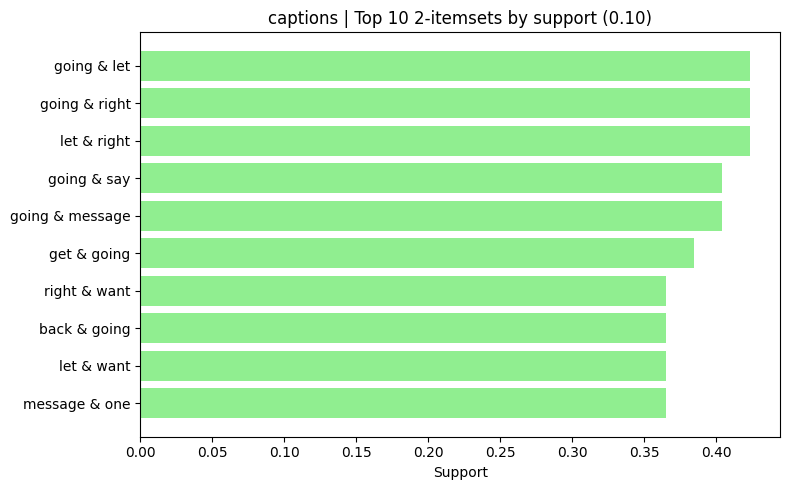

Saved: Lab3_PatternMining_Jaben/captions_top2itemsets_support_supp10.png


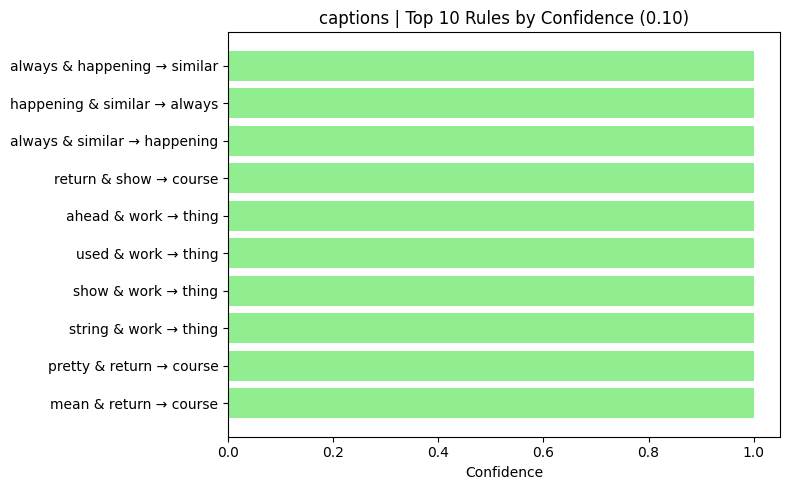

Saved: Lab3_PatternMining_Jaben/captions_top3itemsets_confidence_supp10.png


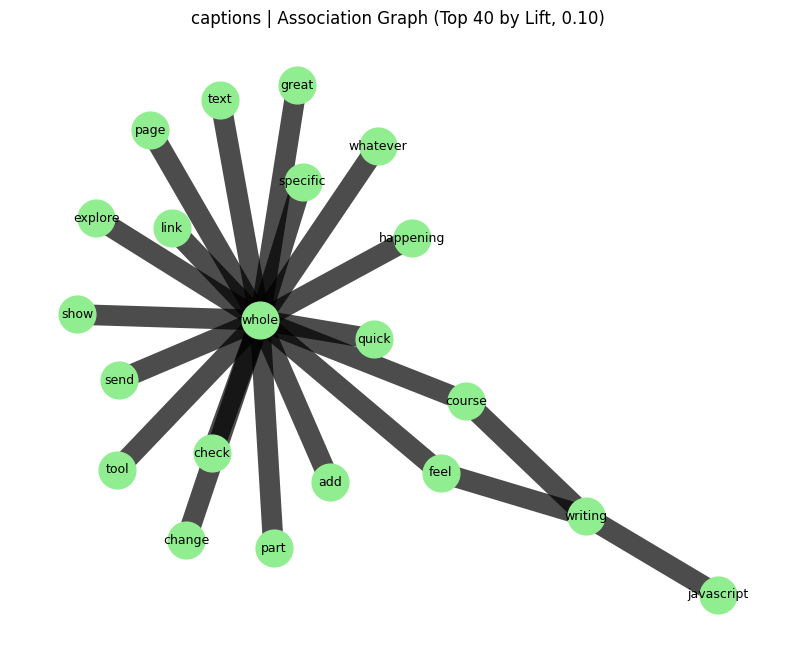

Saved: Lab3_PatternMining_Jaben/captions_assoc_graph_supp10.png


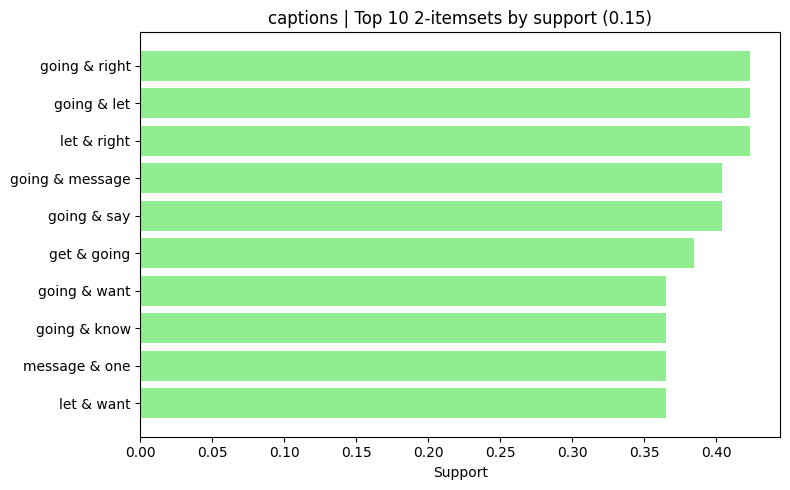

Saved: Lab3_PatternMining_Jaben/captions_top2itemsets_support_supp15.png


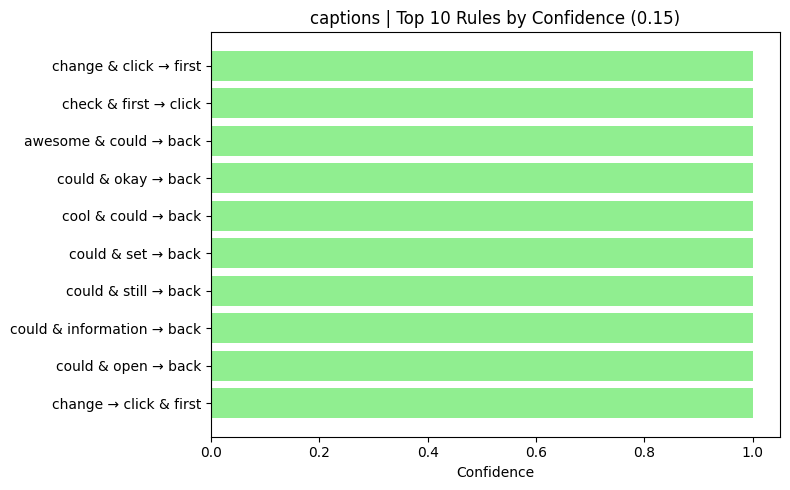

Saved: Lab3_PatternMining_Jaben/captions_top3itemsets_confidence_supp15.png


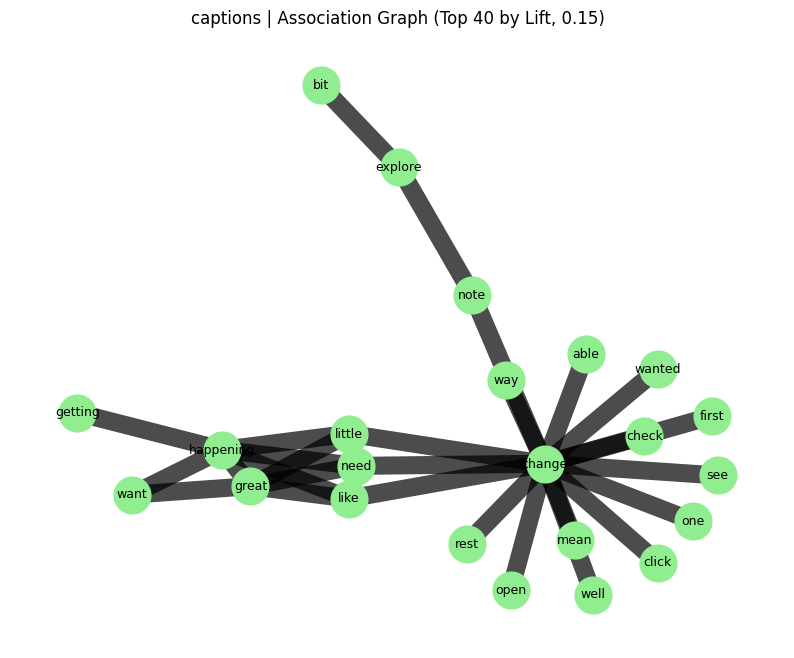

Saved: Lab3_PatternMining_Jaben/captions_assoc_graph_supp15.png


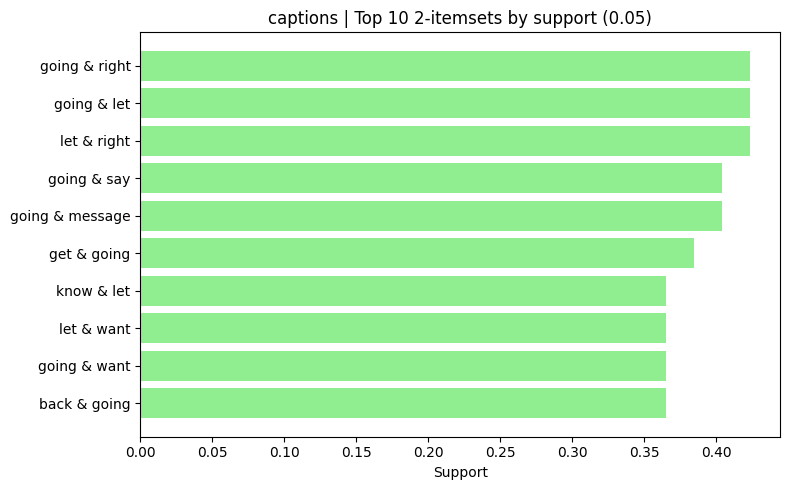

Saved: Lab3_PatternMining_Jaben/captions_top2itemsets_support_supp05.png


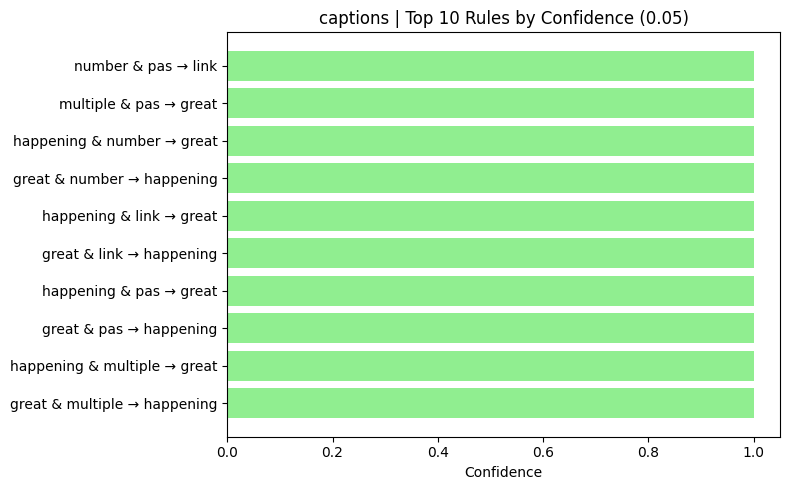

Saved: Lab3_PatternMining_Jaben/captions_top3itemsets_confidence_supp05.png


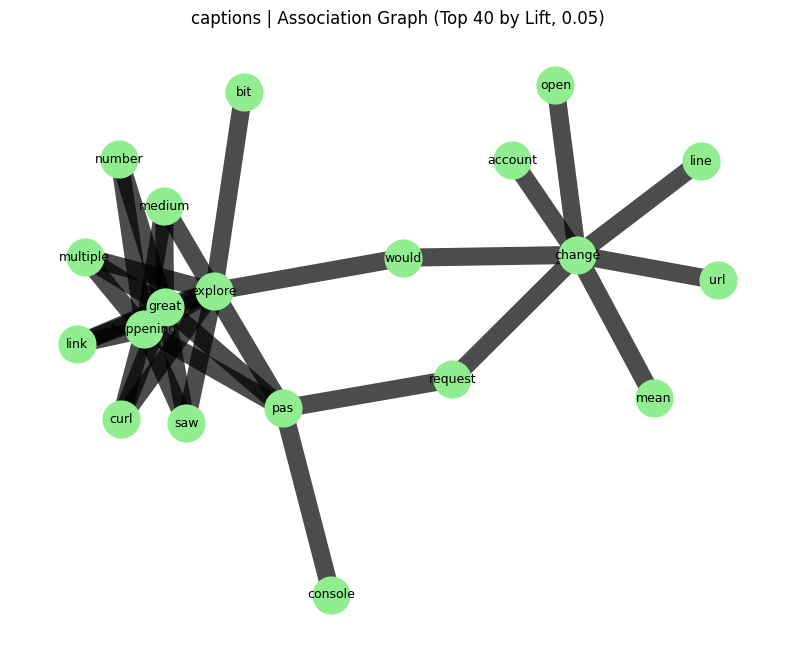

Saved: Lab3_PatternMining_Jaben/captions_assoc_graph_supp05.png

Processing COMMENTS
[comments] No itemsets at 0.30
[comments] Skipping rule-based plots at 0.30 (no rules file found or is empty).
[comments] No itemsets at 0.20
[comments] Skipping rule-based plots at 0.20 (no rules file found or is empty).


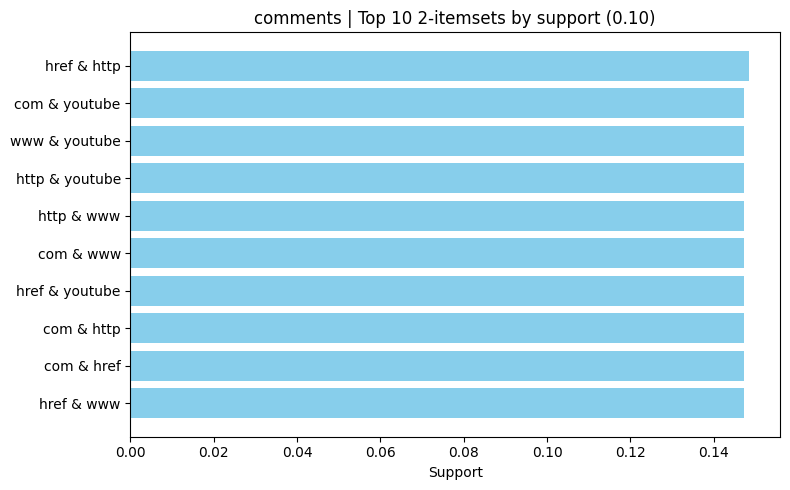

Saved: Lab3_PatternMining_Jaben/comments_top2itemsets_support_supp10.png


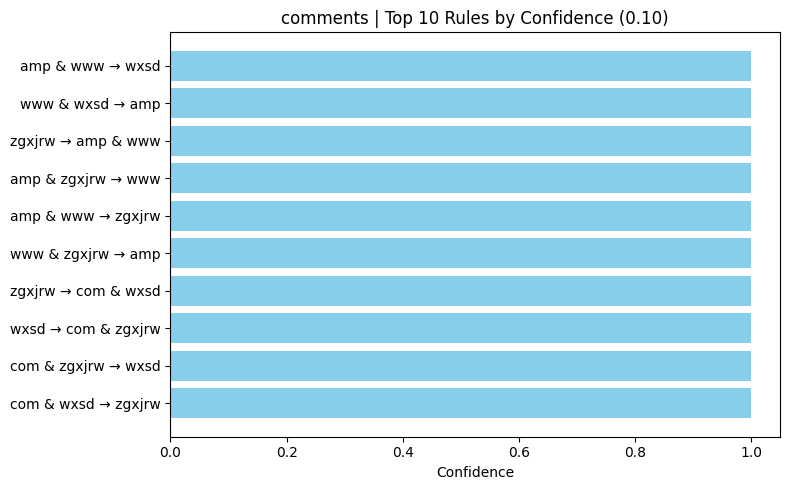

Saved: Lab3_PatternMining_Jaben/comments_top3itemsets_confidence_supp10.png


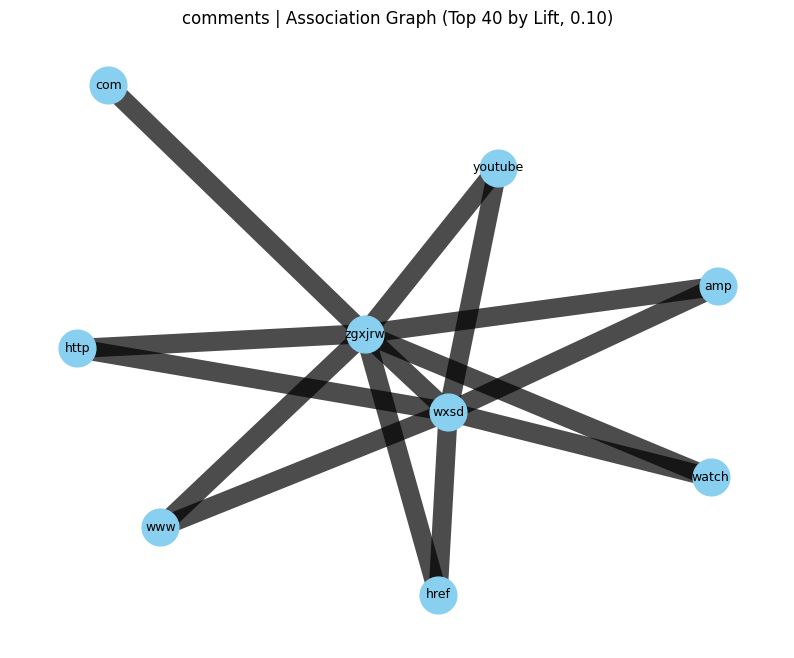

Saved: Lab3_PatternMining_Jaben/comments_assoc_graph_supp10.png
[comments] No 2-itemsets at 0.15
[comments] Skipping rule-based plots at 0.15 (no rules file found or is empty).


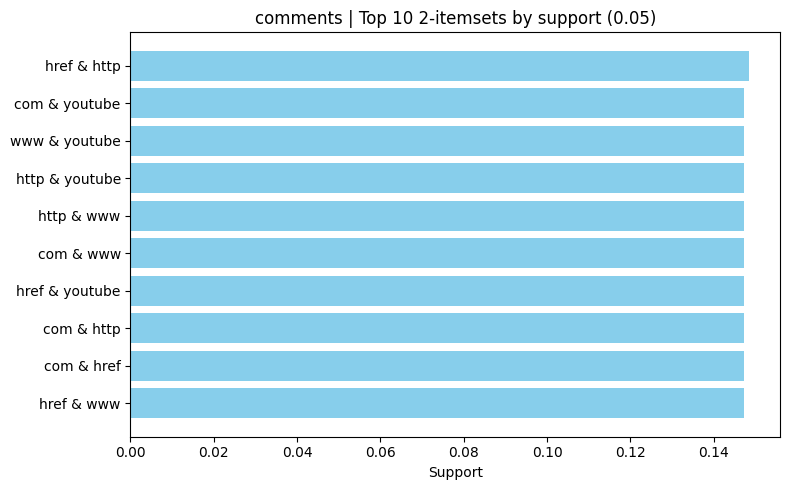

Saved: Lab3_PatternMining_Jaben/comments_top2itemsets_support_supp05.png


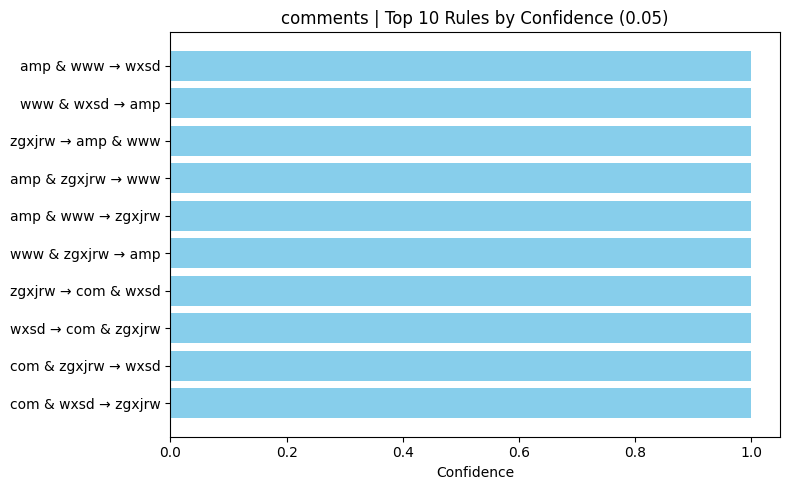

Saved: Lab3_PatternMining_Jaben/comments_top3itemsets_confidence_supp05.png


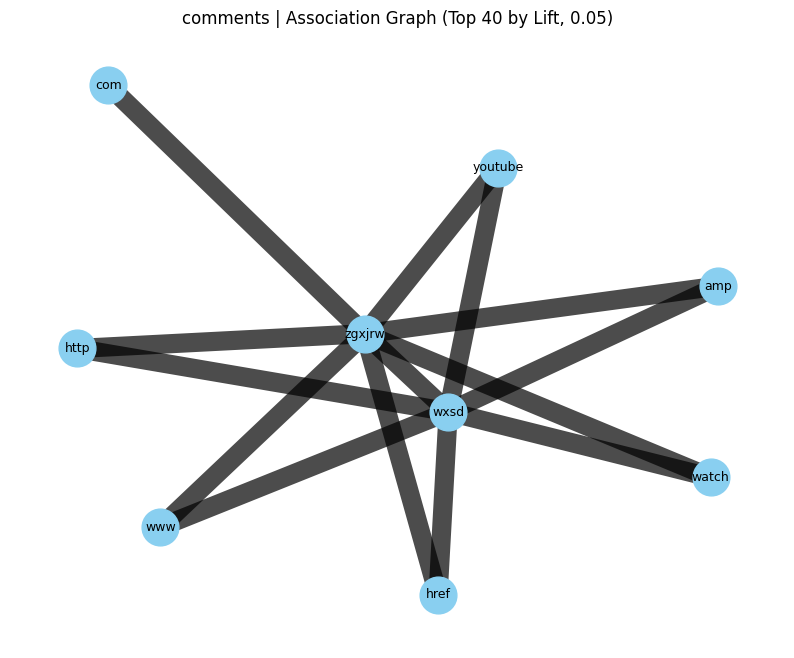

Saved: Lab3_PatternMining_Jaben/comments_assoc_graph_supp05.png


In [25]:
# Define which supports exist for each dataset
available_supports = {
    "captions": ["0.30", "0.20", "0.10", "0.15", "0.05"],
    "comments": ["0.30", "0.20", "0.10", "0.15", "0.05"]
}

# Loop through datasets and their valid support levels
for label, supports in available_supports.items():
    print(f"\nProcessing {label.upper()}")
    for supp_key in supports:
        # Top 10 2-itemsets by support
        plot_topN_itemsets(label, supp_key, length=2, metric="support")

        # Top 10 3-itemsets by confidence and Association Graph (only if rules exist)
        rules_path = os.path.join(OUT_DIR, f"{label}_association_rules_{SUPP[supp_key]}.csv")
        if os.path.exists(rules_path) and os.path.getsize(rules_path) > 0:
             # Pass the correct support suffix to load_rules
            rules_df = load_rules(label, SUPP[supp_key])
            if not rules_df.empty:
                plot_top3_confidence(label, supp_key)
                graph_from_rules(label, supp_key)
            else:
                 print(f"[{label}] Skipping rule-based plots at {supp_key} (no rules found after loading).")
        else:
            print(f"[{label}] Skipping rule-based plots at {supp_key} (no rules file found or is empty).")

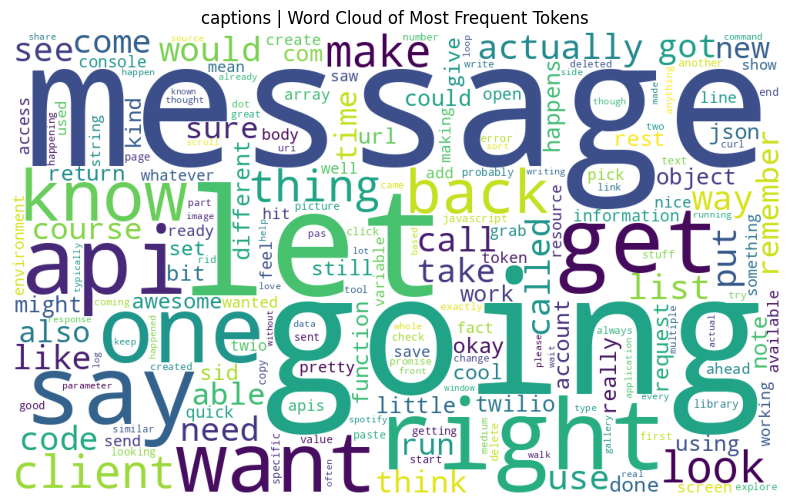

Saved: Lab3_PatternMining_Jaben/captions_wordcloud.png


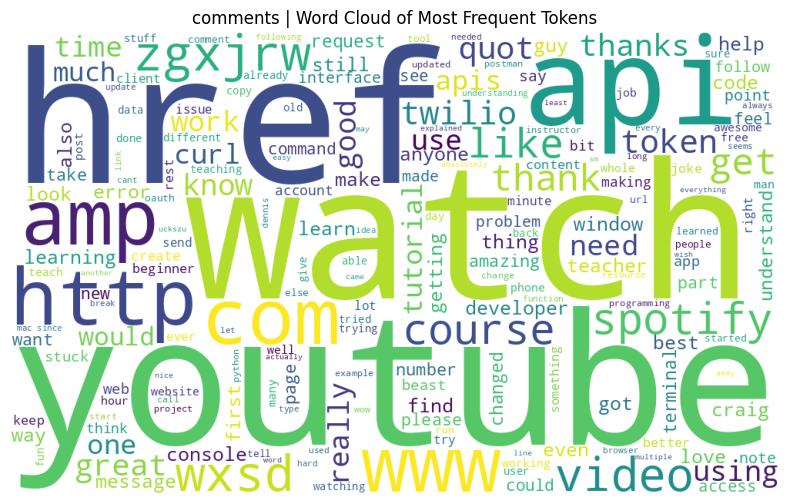

Saved: Lab3_PatternMining_Jaben/comments_wordcloud.png


In [26]:
# WORD CLOUDS (from one-hot data)
wordcloud_from_onehot(onehot_captions, "captions")
wordcloud_from_onehot(onehot_comments, "comments")

captions  comments
amp      0.000000  0.145939
api      0.403846  0.154822
back     0.365385  0.000000
client   0.365385  0.000000
com      0.000000  0.147208
course   0.000000  0.110406
get      0.384615  0.088832
going    0.576923  0.000000
href     0.000000  0.158629
http     0.000000  0.151015
know     0.365385  0.000000
let      0.442308  0.000000
like     0.000000  0.098985
look     0.346154  0.000000
make     0.346154  0.000000
message  0.634615  0.000000
one      0.403846  0.000000
right    0.442308  0.000000
say      0.442308  0.000000
spotify  0.000000  0.112944
thing    0.346154  0.000000
video    0.000000  0.124365
want     0.384615  0.000000
watch    0.000000  0.167513
www      0.000000  0.147208
wxsd     0.000000  0.144670
youtube  0.000000  0.159898
zgxjrw   0.000000  0.144670

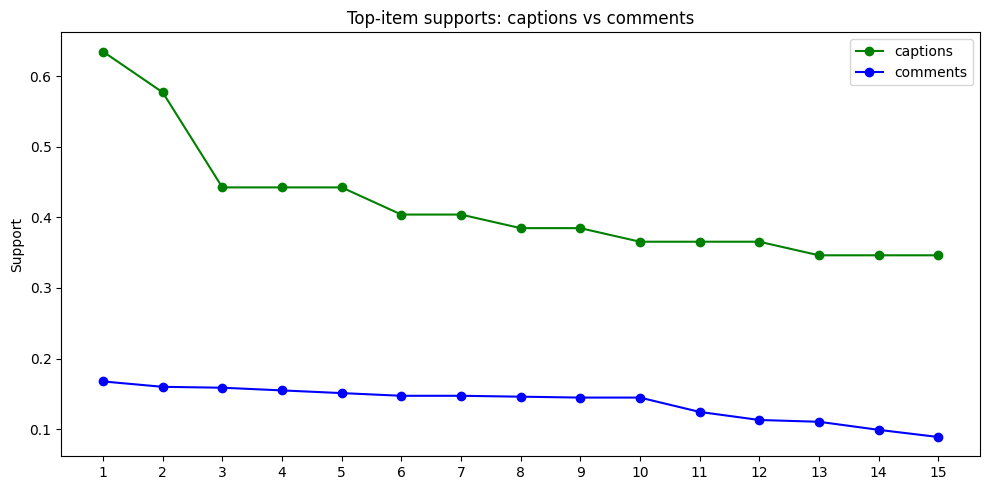

Saved: Lab3_PatternMining_Jaben/compare_top_items.png


In [27]:
# Compare patterns — captions vs comments
def compare_patterns(onehot_a, onehot_b, label_a="captions", label_b="comments", top_n=15):
    # Compute average item presence (support) for each dataset
    sa = onehot_a.astype(bool).mean(axis=0).sort_values(ascending=False).head(top_n)
    sb = onehot_b.astype(bool).mean(axis=0).sort_values(ascending=False).head(top_n)

    # Combine for quick tabular comparison
    cmp = pd.DataFrame({label_a: sa, label_b: sb}).fillna(0)
    display(cmp)

    # Plot support comparison lines
    plt.figure(figsize=(10,5))
    plt.plot(range(len(sa)), sa.values, marker="o", label=label_a, color="green")
    plt.plot(range(len(sb)), sb.values, marker="o", label=label_b, color="blue")
    plt.xticks(range(top_n), range(1, top_n+1))
    plt.ylabel("Support")
    plt.title("Top-item supports: captions vs comments")
    plt.legend()
    plt.tight_layout()
    out = os.path.join(OUT_DIR, "compare_top_items.png")
    plt.savefig(out, dpi=200, bbox_inches="tight")
    plt.show()
    print("Saved:", out)

# Run comparison
compare_patterns(onehot_captions, onehot_comments)

In [29]:
# Save final cleaned dataset with itemsets and rules
# Combines all available itemsets/rules files for each label into two master CSVs.
def consolidate_outputs(label: str):
    fis_files = sorted(glob.glob(f"{label}_frequent_itemsets_*.csv"))
    rules_files = sorted(glob.glob(f"{label}_association_rules_*.csv"))

    all_fis = []
    for p in fis_files:
        try:
            df = pd.read_csv(p)
            df["src_file"] = os.path.basename(p)
            all_fis.append(df)
        except Exception:
            pass
    all_rules = []
    for p in rules_files:
        try:
            df = pd.read_csv(p)
            df["src_file"] = os.path.basename(p)
            all_rules.append(df)
        except Exception:
            pass

    fis_out = pd.concat(all_fis, ignore_index=True) if all_fis else pd.DataFrame()
    rules_out = pd.concat(all_rules, ignore_index=True) if all_rules else pd.DataFrame()

    fis_path = os.path.join(OUT_DIR, f"{label}_FINAL_frequent_itemsets.csv")
    rules_path = os.path.join(OUT_DIR, f"{label}_FINAL_association_rules.csv")
    fis_out.to_csv(fis_path, index=False)
    rules_out.to_csv(rules_path, index=False)
    print("Saved:", fis_path, "|", rules_path)

consolidate_outputs("captions")
consolidate_outputs("comments")

Saved: Lab3_PatternMining_Jaben/captions_FINAL_frequent_itemsets.csv | Lab3_PatternMining_Jaben/captions_FINAL_association_rules.csv
Saved: Lab3_PatternMining_Jaben/comments_FINAL_frequent_itemsets.csv | Lab3_PatternMining_Jaben/comments_FINAL_association_rules.csv


In [30]:
# Import
import shutil, os, datetime

# Create
timestamp = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
zip_base = f"{OUT_DIR}_{timestamp}"
zip_path = shutil.make_archive(zip_base, 'zip', OUT_DIR)

# Display
size_mb = os.path.getsize(zip_path) / 1e6
print(f"Zipped successfully → {zip_path}")
print(f"Size: {size_mb:.2f} MB")

Zipped successfully → /content/Lab3_PatternMining_Jaben_20251101_153015.zip
Size: 160.36 MB
